<a href="https://colab.research.google.com/github/AnumahAdeizaStephen/ResNet-Tutorial-/blob/main/AI_GRID_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Network Pipeline for Particle Interaction Event Anaysis**
## **Objective**


```
Replace the existing signal processing pipeline with neural networks for:
1.  Main event detection and localization.
2.  Amplitude prediction & Pulse time estimation.
```
## **Existing Approach:**

Input:.bin, Output: Event visualization plots


```
1.  Uses an 11X11 grid to model events, and each has multiple waveforms from different pixels.
2.  Sets channel flags: 1 (8 anode: neighbouring events), 2 (cathode), 3 (anode: main event), with each waveform having 160 time samples.
3.  Amplitude estimation (low - high)
4.  Pulse time (curve) fitting (using the stepish_func error function to find pulse timing).
5.  Single-pixel event filtering: Looks for events with exactly 1 (neighbouring events), 2 (cathode), 3 (anode)
6.  Calibration: per-pixel gain calibration using Gaussian fits.
7.  Energy calculation: converts amplitude to keV, using hard-coded algorithms.
```
## **Insights**


```
- 11x11 grid: detector pixel array.
- All pixels triggared in each event.
- A, t: Amplitude and pulse time (in samples: 0-158 range).
```
## **Method**



```
(Load .bin file using the existing 'Ideas' class.)
1.  Extract waveforms and group by timestamp (events).
2.  Create 11x11 x 160 data cubes (pixels x time samples).
3.  Train a convolutional Neural Network to:
    - Detect main event location (classification)
    - Predict amplitude (regresssion)
    - Predict pulse time (regression)
4.  Use existing calculated ampliutdes/tines as ground truth.
```



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as  nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from pathlib import Path
import os
import yaml
from tqdm import tqdm
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import erf

from google.colab import drive
drive.mount('/content/drive')

#Set random seeds for reporoducibility
torch.manual_seed(42)
np.random.seed(42)

#Path to binary data and config file
BINARY_DATA = "/content/scan_x0.13_y0.06_2025-10-23__11_25_26.bin"
CONFIG = '/content/config.yaml'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Path to config file
CONFIG = '/content/config.yaml'

DATA_PATH = 'drive/MyDrive/ColabNotebooks/ScatterAnalysis/data/'

## BINARY_DATA = f'{DATA_PATH}/scan_x0.13_y0.08_2025-10-23__11_48_39.bin'
# BINARY_DATA = f'{DATA_PATH}/scan_x0.13_y0.10_2025-10-23__12_10_59.bin'
# BINARY_DATA = f'{DATA_PATH}/scan_x0.13_y0.12_2025-10-23__12_33_43.bin'
# BINARY_DATA = f'{DATA_PATH}/scan_x0.15_y0.0_2025-09-09__15_46_28.bin'
BINARY_DATA = '/content/scan_x0.13_y0.06_2025-10-23__11_25_26.bin'

In [21]:
!ls

config.yaml  drive  sample_data  scan_x0.13_y0.06_2025-10-23__11_25_26.bin


Define the calculate_pulse_time_simple function (to speedily calculate the pulse time using threshold crossing), fit_waveform(function to fit a single waveform - modified for ProcessPoolExecutor), and the Ideas class (to load the data).

Data loaded from original data file "/content/scan_x0.13_y0.06_2025-10-23__11_25_26.bin" with shapes
	waveforms: (947771, 160), timestamp: (947771,), x: (947771,), y: (947771,), channel_flag: (947771,)
Data saved to cache file "scan_x0.13_y0.06_2025-10-23__11_25_26.npy"
Before filtering: 947771 waveform entries
   timestamp    x    y  channel_flag
0  789655439  255  255             2
1  789655439   11    8             3
2  789655439   11    7             1
3  789655439   10    8             1
4  789655439   11    9             1
5  789655439   10    7             1
6  789655439   10    9             1
7  789655439   10    8             3
8  789655439   10    7             1
9  789655439    9    8             1
Filtering single pixel events. This usually takes a while


Calculating amplitudes:   0%|          | 0/580414 [00:00<?, ?it/s]/tmp/ipython-input-1742191383.py:161: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pocv = curve_fit(stepish_func, x, w, p0 = (np.nanmean(x)/2, np.min(w), np.max(w) - np.min(w), 1.0, 1.0), maxfev=10000)
Calculating amplitudes:   1%|          | 3040/580414 [00:03<13:54, 692.14it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   1%|          | 4197/580414 [00:04<15:31, 618.31it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   1%|          | 6466/580414 [00:09<26:20, 363.25it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   1%|▏         | 8212/580414 [00:11<08:42, 1095.45it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   2%|▏         | 9941/580414 [00:14<21:53, 434.15it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   2%|▏         | 12341/580414 [00:17<13:49, 685.22it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   3%|▎         | 15989/580414 [00:22<14:09, 664.79it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   3%|▎         | 16069/580414 [00:23<17:37, 533.57it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   3%|▎         | 16167/580414 [00:23<19:12, 489.40it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   3%|▎         | 16368/580414 [00:23<17:27, 538.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   3%|▎         | 17047/580414 [00:24<12:50, 731.13it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   3%|▎         | 18756/580414 [00:26<10:38, 879.87it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   4%|▎         | 20555/580414 [00:28<14:03, 663.38it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   4%|▎         | 21401/580414 [00:29<15:24, 604.91it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   4%|▍         | 22655/580414 [00:31<13:25, 692.15it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   4%|▍         | 23487/580414 [00:32<14:53, 623.16it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   4%|▍         | 23609/580414 [00:33<33:55, 273.54it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   4%|▍         | 23752/580414 [00:34<30:38, 302.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   5%|▍         | 26975/580414 [00:39<14:21, 642.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   5%|▍         | 27663/580414 [00:40<11:03, 833.62it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   5%|▍         | 28335/580414 [00:40<10:11, 902.36it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   5%|▌         | 29161/580414 [00:42<12:55, 711.15it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   5%|▌         | 30151/580414 [00:43<12:14, 749.42it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   5%|▌         | 30499/580414 [00:44<15:35, 588.07it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   6%|▌         | 32621/580414 [00:47<18:16, 499.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   6%|▌         | 32731/580414 [00:48<38:20, 238.10it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   6%|▌         | 32994/580414 [00:48<30:07, 302.81it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   6%|▌         | 33848/580414 [00:50<14:39, 621.76it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   6%|▌         | 35939/580414 [00:52<14:11, 639.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   6%|▋         | 36546/580414 [00:53<13:06, 691.22it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   7%|▋         | 38380/580414 [00:55<13:05, 689.90it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   7%|▋         | 39044/580414 [00:56<11:29, 785.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   7%|▋         | 42672/580414 [01:01<14:22, 623.16it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   7%|▋         | 43359/580414 [01:03<15:05, 593.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   8%|▊         | 43782/580414 [01:03<14:22, 622.28it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   8%|▊         | 44245/580414 [01:04<16:16, 549.07it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   8%|▊         | 45189/580414 [01:05<13:49, 644.92it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   8%|▊         | 45340/580414 [01:06<17:34, 507.36it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   8%|▊         | 46335/580414 [01:07<13:24, 663.96it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   8%|▊         | 46927/580414 [01:08<10:05, 880.79it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   8%|▊         | 48587/580414 [01:10<13:55, 636.82it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   8%|▊         | 48759/580414 [01:10<14:52, 595.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   9%|▊         | 50130/580414 [01:12<15:30, 569.64it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   9%|▊         | 50267/580414 [01:13<22:22, 394.75it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   9%|▉         | 51207/580414 [01:15<26:08, 337.40it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   9%|▉         | 51743/580414 [01:16<13:29, 652.92it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   9%|▉         | 52252/580414 [01:16<14:37, 601.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   9%|▉         | 52334/580414 [01:17<16:53, 520.86it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   9%|▉         | 52835/580414 [01:18<20:14, 434.39it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:   9%|▉         | 54014/580414 [01:19<14:11, 618.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|▉         | 55292/580414 [01:21<11:35, 755.36it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|▉         | 55479/580414 [01:22<18:50, 464.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|▉         | 56423/580414 [01:23<19:17, 452.69it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|▉         | 56957/580414 [01:24<15:35, 559.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|▉         | 57082/580414 [01:24<18:21, 474.97it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|▉         | 57801/580414 [01:25<13:50, 628.97it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|▉         | 58034/580414 [01:26<20:10, 431.46it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|█         | 58838/580414 [01:28<26:01, 334.08it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  10%|█         | 60785/580414 [01:31<12:03, 718.55it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 61058/580414 [01:32<13:57, 619.96it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 61761/580414 [01:33<14:58, 577.06it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 62094/580414 [01:33<15:19, 563.40it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 62643/580414 [01:34<14:24, 599.01it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 62846/580414 [01:35<14:54, 578.41it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 63035/580414 [01:35<14:41, 587.11it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 63641/580414 [01:36<12:59, 662.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 64052/580414 [01:37<21:12, 405.66it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█         | 64901/580414 [01:38<14:51, 578.05it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█▏        | 65363/580414 [01:39<12:51, 667.42it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█▏        | 66234/580414 [01:41<25:49, 331.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  11%|█▏        | 66352/580414 [01:41<29:01, 295.14it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 67221/580414 [01:43<11:29, 744.19it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 67868/580414 [01:44<16:06, 530.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 68044/580414 [01:44<20:01, 426.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 69063/580414 [01:46<16:30, 516.17it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 69402/580414 [01:46<16:00, 532.01it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 69578/580414 [01:47<15:35, 546.03it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 70633/580414 [01:48<10:05, 842.06it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 70920/580414 [01:48<13:37, 622.88it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 71996/580414 [01:50<13:22, 633.34it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 72439/580414 [01:50<13:45, 615.67it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  12%|█▏        | 72519/580414 [01:51<16:34, 510.96it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  13%|█▎        | 72852/580414 [01:51<13:53, 608.76it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  13%|█▎        | 74363/580414 [01:54<28:07, 299.93it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  13%|█▎        | 76656/580414 [01:57<11:21, 739.55it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  13%|█▎        | 77087/580414 [01:58<11:00, 762.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  13%|█▎        | 77429/580414 [01:58<15:47, 530.67it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  14%|█▍        | 80064/580414 [02:02<11:44, 710.07it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  14%|█▍        | 80599/580414 [02:03<14:09, 588.22it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  14%|█▍        | 81267/580414 [02:04<12:47, 650.69it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  14%|█▍        | 82209/580414 [02:05<16:10, 513.10it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  14%|█▍        | 82474/580414 [02:06<25:58, 319.49it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  15%|█▍        | 84795/580414 [02:10<11:27, 720.61it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  15%|█▍        | 85379/580414 [02:11<11:08, 740.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  15%|█▍        | 85956/580414 [02:12<11:38, 707.91it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  15%|█▌        | 87266/580414 [02:14<13:55, 590.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  15%|█▌        | 87435/580414 [02:14<14:11, 578.99it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  15%|█▌        | 88652/580414 [02:16<11:22, 720.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  16%|█▌        | 91313/580414 [02:19<16:48, 485.18it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  16%|█▌        | 92135/580414 [02:21<13:28, 603.90it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  16%|█▌        | 92249/580414 [02:22<30:49, 263.94it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  17%|█▋        | 100222/580414 [02:31<12:29, 640.96it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  17%|█▋        | 100560/580414 [02:32<14:07, 566.28it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  18%|█▊        | 101958/580414 [02:35<20:08, 395.97it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  18%|█▊        | 102124/580414 [02:36<15:52, 501.92it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  18%|█▊        | 102583/580414 [02:36<11:35, 686.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▊        | 107844/580414 [02:42<11:10, 704.57it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▊        | 108038/580414 [02:42<13:14, 594.51it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▊        | 108143/580414 [02:43<14:23, 546.78it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▊        | 108747/580414 [02:44<13:25, 585.65it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▉        | 108887/580414 [02:44<17:22, 452.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▉        | 109093/580414 [02:44<16:35, 473.55it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▉        | 109565/580414 [02:45<13:41, 573.16it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▉        | 111276/580414 [02:48<17:59, 434.42it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  19%|█▉        | 113052/580414 [02:51<19:41, 395.65it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  20%|█▉        | 116024/580414 [02:55<14:24, 536.94it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  20%|██        | 118059/580414 [02:58<09:57, 773.64it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  21%|██        | 119408/580414 [03:00<14:53, 515.89it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  21%|██        | 119506/580414 [03:01<32:29, 236.39it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  21%|██        | 121292/580414 [03:05<26:13, 291.82it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  21%|██        | 122748/580414 [03:07<09:33, 797.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 126332/580414 [03:11<11:23, 664.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 127112/580414 [03:13<20:52, 362.03it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 127252/580414 [03:14<30:02, 251.45it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 127418/580414 [03:14<33:25, 225.87it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 128128/580414 [03:15<10:48, 697.60it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 128426/580414 [03:16<10:26, 721.64it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 129624/580414 [03:17<10:05, 744.68it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 129722/580414 [03:18<13:00, 577.79it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 129938/580414 [03:18<12:34, 596.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  22%|██▏       | 130023/580414 [03:18<16:35, 452.26it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  23%|██▎       | 131125/580414 [03:20<09:30, 787.77it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  23%|██▎       | 131529/580414 [03:20<11:05, 674.07it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  23%|██▎       | 133511/580414 [03:23<09:42, 767.27it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  23%|██▎       | 134470/580414 [03:24<11:05, 669.89it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  23%|██▎       | 134823/580414 [03:24<10:49, 686.19it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  23%|██▎       | 135177/580414 [03:25<09:27, 784.27it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  23%|██▎       | 135349/580414 [03:25<12:09, 609.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  23%|██▎       | 136305/580414 [03:27<18:55, 391.03it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  24%|██▎       | 136949/580414 [03:29<16:20, 452.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  24%|██▎       | 137435/580414 [03:29<11:18, 652.41it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  24%|██▍       | 139017/580414 [03:31<10:20, 711.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  24%|██▍       | 141619/580414 [03:35<15:42, 465.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  25%|██▍       | 144391/580414 [03:39<15:18, 474.75it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  25%|██▌       | 147143/580414 [03:44<13:09, 548.64it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  25%|██▌       | 147739/580414 [03:45<11:33, 624.19it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  26%|██▌       | 149536/580414 [03:47<09:53, 725.83it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  26%|██▋       | 152981/580414 [03:51<08:47, 809.59it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  26%|██▋       | 153691/580414 [03:52<10:14, 694.55it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  27%|██▋       | 154906/580414 [03:54<20:17, 349.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  27%|██▋       | 155433/580414 [03:55<17:59, 393.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  27%|██▋       | 156615/580414 [03:57<08:01, 880.61it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  27%|██▋       | 158457/580414 [04:00<12:12, 576.00it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  28%|██▊       | 160553/580414 [04:02<10:12, 684.95it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  28%|██▊       | 163883/580414 [04:06<15:59, 434.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  29%|██▊       | 165781/580414 [04:10<09:40, 713.70it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  29%|██▊       | 166089/580414 [04:11<10:24, 663.33it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  29%|██▊       | 166565/580414 [04:11<14:25, 478.25it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  29%|██▊       | 166789/580414 [04:12<11:49, 583.13it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  29%|██▉       | 170436/580414 [04:16<10:18, 662.48it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  30%|██▉       | 173536/580414 [04:21<19:58, 339.63it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  30%|███       | 175007/580414 [04:23<11:13, 601.96it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  30%|███       | 175407/580414 [04:24<10:06, 668.12it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  30%|███       | 175958/580414 [04:24<11:39, 578.06it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  30%|███       | 176030/580414 [04:25<14:25, 467.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  30%|███       | 176089/580414 [04:25<17:13, 391.11it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  30%|███       | 176290/580414 [04:25<13:50, 486.55it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  31%|███       | 177268/580414 [04:27<12:16, 547.45it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  31%|███       | 177966/580414 [04:28<10:38, 630.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  31%|███       | 178626/580414 [04:29<10:07, 661.48it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  31%|███       | 179924/580414 [04:30<09:58, 668.93it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  31%|███▏      | 182160/580414 [04:35<17:31, 378.83it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 183300/580414 [04:37<10:37, 623.22it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 184978/580414 [04:39<09:18, 707.51it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 185661/580414 [04:40<10:44, 612.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 186516/580414 [04:41<11:16, 582.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 186662/580414 [04:42<14:07, 464.44it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 188053/580414 [04:43<08:02, 812.48it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 188152/580414 [04:44<10:54, 599.23it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 188232/580414 [04:44<13:20, 489.79it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  32%|███▏      | 188379/580414 [04:44<14:16, 457.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  33%|███▎      | 189508/580414 [04:46<18:51, 345.44it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  33%|███▎      | 189880/580414 [04:47<23:07, 281.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  33%|███▎      | 190117/580414 [04:48<19:40, 330.48it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  33%|███▎      | 190708/580414 [04:49<10:11, 636.95it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  33%|███▎      | 191554/580414 [04:50<10:34, 612.66it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  33%|███▎      | 194281/580414 [04:54<10:30, 612.82it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  34%|███▎      | 195027/580414 [04:55<09:36, 668.22it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  34%|███▍      | 196612/580414 [04:57<09:13, 692.86it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  34%|███▍      | 197103/580414 [04:58<15:57, 400.21it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  34%|███▍      | 197508/580414 [04:58<11:57, 533.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  34%|███▍      | 197572/580414 [04:59<18:47, 339.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  34%|███▍      | 197709/580414 [05:00<28:41, 222.33it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  34%|███▍      | 199254/580414 [05:02<11:13, 566.16it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  35%|███▍      | 201628/580414 [05:05<09:41, 651.67it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  35%|███▍      | 201803/580414 [05:05<13:54, 453.83it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  35%|███▌      | 205933/580414 [05:10<11:10, 558.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  36%|███▌      | 206189/580414 [05:11<11:01, 565.79it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  36%|███▌      | 208253/580414 [05:15<20:58, 295.83it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  36%|███▌      | 208484/580414 [05:15<17:04, 363.18it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  36%|███▌      | 209443/580414 [05:17<10:43, 576.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  36%|███▌      | 210002/580414 [05:18<12:14, 504.12it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  37%|███▋      | 212999/580414 [05:22<09:52, 620.18it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  37%|███▋      | 213567/580414 [05:23<08:45, 697.77it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  37%|███▋      | 213891/580414 [05:23<08:47, 694.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  37%|███▋      | 214046/580414 [05:24<13:58, 436.98it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  37%|███▋      | 217458/580414 [05:30<09:26, 640.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  38%|███▊      | 219125/580414 [05:32<11:20, 530.63it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  38%|███▊      | 219711/580414 [05:33<07:38, 787.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  38%|███▊      | 221848/580414 [05:36<09:57, 600.43it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  38%|███▊      | 222030/580414 [05:36<10:56, 545.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  39%|███▉      | 226573/580414 [05:43<12:25, 474.49it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  39%|███▉      | 227742/580414 [05:45<09:54, 592.85it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  39%|███▉      | 228375/580414 [05:46<08:06, 723.85it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  39%|███▉      | 228842/580414 [05:46<08:08, 719.22it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  39%|███▉      | 229256/580414 [05:47<08:03, 726.42it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  40%|███▉      | 229421/580414 [05:47<10:53, 536.69it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  40%|███▉      | 230362/580414 [05:49<08:04, 721.95it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  40%|███▉      | 230804/580414 [05:49<08:14, 707.61it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  40%|███▉      | 231530/580414 [05:50<10:07, 574.02it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  40%|███▉      | 231996/580414 [05:51<10:32, 551.17it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  40%|████      | 232676/580414 [05:53<15:16, 379.23it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  40%|████      | 234111/580414 [05:56<10:50, 532.75it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  40%|████      | 234180/580414 [05:56<15:55, 362.34it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  41%|████      | 235737/580414 [05:58<08:24, 683.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  41%|████      | 237023/580414 [06:00<13:06, 436.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  41%|████      | 237813/580414 [06:01<09:30, 600.68it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  41%|████▏     | 239581/580414 [06:04<07:06, 799.55it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  42%|████▏     | 241028/580414 [06:06<20:18, 278.55it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  42%|████▏     | 241671/580414 [06:08<19:19, 292.08it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  42%|████▏     | 241802/580414 [06:09<18:38, 302.76it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  42%|████▏     | 243131/580414 [06:10<06:58, 805.30it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  42%|████▏     | 243407/580414 [06:11<14:03, 399.52it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  42%|████▏     | 243943/580414 [06:12<09:11, 610.03it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  43%|████▎     | 248457/580414 [06:18<08:08, 680.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  43%|████▎     | 248578/580414 [06:18<09:22, 589.93it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  43%|████▎     | 249220/580414 [06:19<15:53, 347.51it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  43%|████▎     | 249531/580414 [06:20<18:25, 299.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  43%|████▎     | 250755/580414 [06:23<08:55, 615.98it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  43%|████▎     | 251292/580414 [06:24<09:28, 578.91it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  43%|████▎     | 251525/580414 [06:24<09:43, 564.06it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  44%|████▎     | 253005/580414 [06:26<10:08, 537.62it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  44%|████▎     | 253580/580414 [06:27<09:45, 558.49it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  44%|████▍     | 254807/580414 [06:29<08:03, 673.94it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  44%|████▍     | 255756/580414 [06:30<08:39, 625.54it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  44%|████▍     | 256469/580414 [06:31<07:54, 682.00it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  44%|████▍     | 258102/580414 [06:34<13:02, 411.64it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  45%|████▌     | 261851/580414 [06:39<07:26, 714.03it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  45%|████▌     | 262167/580414 [06:39<08:07, 653.48it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  45%|████▌     | 262344/580414 [06:40<09:19, 568.01it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  45%|████▌     | 263349/580414 [06:41<06:25, 821.69it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  46%|████▌     | 266816/580414 [06:46<12:50, 407.15it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  46%|████▌     | 267979/580414 [06:48<14:55, 348.92it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  46%|████▋     | 269370/580414 [06:50<07:51, 659.43it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 269894/580414 [06:51<08:07, 636.94it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 270377/580414 [06:52<09:19, 554.06it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 270558/580414 [06:52<08:41, 593.63it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 271140/580414 [06:53<07:39, 673.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 271598/580414 [06:54<08:15, 622.97it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 271797/580414 [06:54<07:53, 651.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 272505/580414 [06:55<08:12, 625.62it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 273073/580414 [06:56<07:27, 686.86it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  47%|████▋     | 274706/580414 [06:59<11:06, 458.61it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  48%|████▊     | 278335/580414 [07:04<06:31, 771.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  48%|████▊     | 278587/580414 [07:05<08:18, 605.62it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  48%|████▊     | 280492/580414 [07:07<04:38, 1077.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  48%|████▊     | 280707/580414 [07:08<07:36, 656.22it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  48%|████▊     | 281111/580414 [07:08<08:21, 596.38it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  49%|████▊     | 281547/580414 [07:09<09:36, 518.39it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  49%|████▊     | 281731/580414 [07:10<15:39, 318.07it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  49%|████▊     | 282548/580414 [07:11<07:59, 621.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  49%|████▉     | 283885/580414 [07:13<15:28, 319.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  49%|████▉     | 284807/580414 [07:15<13:58, 352.69it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  49%|████▉     | 285680/580414 [07:16<08:22, 587.08it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  49%|████▉     | 286324/580414 [07:17<08:16, 591.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  49%|████▉     | 286844/580414 [07:18<06:55, 706.69it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  50%|████▉     | 287863/580414 [07:19<06:05, 801.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  51%|█████     | 294925/580414 [07:30<09:41, 490.79it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  51%|█████     | 295077/580414 [07:30<10:14, 464.60it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  51%|█████     | 295581/580414 [07:31<10:00, 474.18it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  51%|█████▏    | 297597/580414 [07:33<07:07, 662.00it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 300012/580414 [07:37<07:00, 666.63it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 300326/580414 [07:37<07:01, 664.94it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 300670/580414 [07:38<06:07, 761.50it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 301073/580414 [07:38<07:22, 631.39it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 302392/580414 [07:41<17:18, 267.81it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 302851/580414 [07:42<14:38, 315.91it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 303693/580414 [07:44<08:30, 542.44it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 304424/580414 [07:44<04:53, 941.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  52%|█████▏    | 304642/580414 [07:45<07:31, 610.56it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  53%|█████▎    | 306167/580414 [07:47<08:31, 535.90it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  53%|█████▎    | 306931/580414 [07:48<06:11, 736.23it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  53%|█████▎    | 307187/580414 [07:48<07:50, 581.13it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  53%|█████▎    | 307424/580414 [07:49<08:24, 541.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  53%|█████▎    | 310122/580414 [07:52<06:09, 730.90it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  54%|█████▎    | 310596/580414 [07:53<09:52, 455.32it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  54%|█████▎    | 310952/580414 [07:54<12:39, 354.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  54%|█████▍    | 313198/580414 [07:58<05:37, 790.82it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  54%|█████▍    | 313290/580414 [07:58<07:34, 588.25it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  54%|█████▍    | 313918/580414 [07:59<07:56, 559.31it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  54%|█████▍    | 315396/580414 [08:01<06:12, 712.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  55%|█████▍    | 318795/580414 [08:04<06:47, 641.93it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  55%|█████▍    | 318941/580414 [08:05<08:21, 521.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  55%|█████▌    | 321242/580414 [08:10<19:53, 217.08it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▌    | 322282/580414 [08:11<05:30, 779.92it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▌    | 323830/580414 [08:13<06:34, 650.02it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▌    | 324007/580414 [08:14<07:12, 592.84it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▌    | 324548/580414 [08:14<07:22, 578.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▌    | 325034/580414 [08:15<08:07, 523.72it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▌    | 326172/580414 [08:17<05:29, 772.74it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▌    | 326362/580414 [08:17<09:12, 459.81it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▋    | 326924/580414 [08:18<08:19, 507.29it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  56%|█████▋    | 327490/580414 [08:19<06:10, 682.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 327998/580414 [08:20<11:39, 361.06it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 328122/580414 [08:21<12:55, 325.23it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 329881/580414 [08:25<08:00, 521.51it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 329942/580414 [08:25<09:40, 431.43it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 330137/580414 [08:25<07:58, 522.81it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 330498/580414 [08:26<07:35, 548.50it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 331331/580414 [08:27<07:53, 525.52it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 333029/580414 [08:29<05:40, 726.68it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  57%|█████▋    | 333253/580414 [08:30<05:38, 730.90it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  58%|█████▊    | 333869/580414 [08:31<06:55, 592.69it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  58%|█████▊    | 334329/580414 [08:32<06:18, 650.00it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  58%|█████▊    | 334869/580414 [08:32<08:23, 487.21it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  58%|█████▊    | 335078/580414 [08:33<06:52, 594.19it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  58%|█████▊    | 338494/580414 [08:38<05:26, 742.04it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  58%|█████▊    | 339203/580414 [08:39<05:41, 706.97it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  59%|█████▊    | 339904/580414 [08:40<06:04, 659.20it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  59%|█████▉    | 341069/580414 [08:42<05:41, 700.12it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  59%|█████▉    | 341229/580414 [08:42<07:00, 569.29it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  59%|█████▉    | 342577/580414 [08:44<06:35, 601.96it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  59%|█████▉    | 343661/580414 [08:45<06:00, 657.50it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  60%|█████▉    | 346805/580414 [08:50<05:43, 680.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  60%|█████▉    | 347299/580414 [08:51<05:37, 691.28it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  60%|██████    | 349265/580414 [08:54<07:43, 498.32it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  60%|██████    | 349482/580414 [08:54<06:12, 620.66it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  60%|██████    | 350343/580414 [08:55<03:47, 1010.04it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  61%|██████    | 351377/580414 [08:57<05:19, 717.20it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  61%|██████    | 353052/580414 [08:59<08:06, 467.51it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  61%|██████    | 353766/580414 [09:01<08:44, 432.25it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  61%|██████    | 354469/580414 [09:02<09:05, 414.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  61%|██████    | 354917/580414 [09:03<10:13, 367.34it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  61%|██████    | 355394/580414 [09:04<06:08, 611.14it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  61%|██████▏   | 355632/580414 [09:05<08:41, 430.91it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  62%|██████▏   | 357910/580414 [09:07<06:36, 560.68it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  62%|██████▏   | 358085/580414 [09:08<06:47, 545.89it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  62%|██████▏   | 359042/580414 [09:09<07:04, 521.05it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  62%|██████▏   | 359781/580414 [09:11<06:27, 568.75it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  62%|██████▏   | 361458/580414 [09:15<15:17, 238.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  63%|██████▎   | 365117/580414 [09:20<03:57, 905.95it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  63%|██████▎   | 366358/580414 [09:22<04:22, 816.89it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  63%|██████▎   | 366544/580414 [09:22<06:11, 576.17it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  63%|██████▎   | 366685/580414 [09:23<07:42, 462.02it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  63%|██████▎   | 366978/580414 [09:23<06:36, 537.98it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  63%|██████▎   | 367852/580414 [09:24<05:26, 651.48it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▎   | 369001/580414 [09:26<04:33, 772.39it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▎   | 369605/580414 [09:27<04:27, 788.52it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 371666/580414 [09:30<09:27, 367.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 371754/580414 [09:31<14:26, 240.67it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 371922/580414 [09:31<09:52, 351.83it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 372528/580414 [09:32<05:08, 674.07it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 373071/580414 [09:33<05:12, 662.46it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 373497/580414 [09:33<05:12, 662.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 373827/580414 [09:34<05:03, 681.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 374136/580414 [09:34<05:11, 661.84it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  64%|██████▍   | 374304/580414 [09:35<06:00, 571.93it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  65%|██████▍   | 376241/580414 [09:37<05:51, 580.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  65%|██████▍   | 377037/580414 [09:38<04:59, 679.42it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  65%|██████▍   | 377196/580414 [09:39<06:07, 553.17it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  65%|██████▌   | 377538/580414 [09:39<05:23, 627.81it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  65%|██████▌   | 378605/580414 [09:41<05:35, 601.83it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  65%|██████▌   | 378675/580414 [09:41<07:49, 429.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  65%|██████▌   | 379156/580414 [09:43<09:09, 366.13it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  65%|██████▌   | 379313/580414 [09:44<15:41, 213.57it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  66%|██████▌   | 380217/580414 [09:45<05:42, 583.89it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  66%|██████▌   | 380383/580414 [09:46<06:05, 547.14it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  66%|██████▌   | 382385/580414 [09:48<03:15, 1012.95it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  66%|██████▌   | 383244/580414 [09:50<05:04, 648.00it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  66%|██████▌   | 383912/580414 [09:51<05:32, 591.49it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  66%|██████▌   | 384059/580414 [09:51<06:32, 500.62it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  66%|██████▋   | 384922/580414 [09:52<04:59, 652.77it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 386282/580414 [09:54<05:34, 580.59it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 388713/580414 [09:58<04:36, 692.59it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 390216/580414 [10:00<04:40, 677.75it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 390488/580414 [10:01<05:45, 549.03it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 390699/580414 [10:01<05:43, 552.81it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 390769/580414 [10:01<06:39, 474.14it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 390968/580414 [10:02<05:29, 575.25it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 391301/580414 [10:02<06:23, 492.66it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  67%|██████▋   | 391464/580414 [10:03<06:14, 503.90it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 392059/580414 [10:04<05:13, 601.25it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 392216/580414 [10:04<07:19, 427.87it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 393657/580414 [10:06<04:51, 639.60it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 393913/580414 [10:07<05:39, 549.63it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 394146/580414 [10:07<04:58, 623.06it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 394677/580414 [10:08<04:52, 634.14it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 395355/580414 [10:09<08:41, 354.56it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 395803/580414 [10:11<08:31, 360.78it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 396787/580414 [10:12<04:33, 671.57it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  68%|██████▊   | 397519/580414 [10:13<07:44, 393.46it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  69%|██████▉   | 399053/580414 [10:15<03:27, 874.05it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  69%|██████▉   | 399264/580414 [10:15<04:15, 707.84it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  69%|██████▉   | 399707/580414 [10:16<05:09, 584.36it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  69%|██████▉   | 400716/580414 [10:18<04:44, 631.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  69%|██████▉   | 401177/580414 [10:19<04:52, 612.85it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  69%|██████▉   | 401615/580414 [10:19<04:05, 729.00it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  69%|██████▉   | 402166/580414 [10:20<04:25, 671.31it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  70%|███████   | 407209/580414 [10:28<04:41, 614.78it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  70%|███████   | 408930/580414 [10:30<04:09, 687.41it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  70%|███████   | 409117/580414 [10:30<04:31, 631.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  71%|███████   | 410762/580414 [10:32<03:28, 815.18it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  71%|███████   | 411735/580414 [10:33<03:54, 718.17it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  71%|███████   | 412955/580414 [10:35<03:51, 723.39it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  71%|███████   | 413241/580414 [10:36<07:51, 354.26it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  72%|███████▏  | 418375/580414 [10:44<06:03, 445.63it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  72%|███████▏  | 419972/580414 [10:46<04:00, 668.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  73%|███████▎  | 423404/580414 [10:51<08:31, 307.18it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  73%|███████▎  | 424776/580414 [10:53<04:36, 562.93it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  73%|███████▎  | 425179/580414 [10:54<04:50, 534.01it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  73%|███████▎  | 425348/580414 [10:54<05:27, 473.84it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  73%|███████▎  | 425999/580414 [10:56<04:36, 557.98it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  73%|███████▎  | 426160/580414 [10:56<04:44, 541.31it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  74%|███████▎  | 427279/580414 [10:57<03:56, 646.94it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  74%|███████▎  | 427356/580414 [10:58<06:19, 403.07it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  74%|███████▍  | 428193/580414 [10:59<04:31, 561.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  74%|███████▍  | 428610/580414 [11:00<03:41, 685.75it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  74%|███████▍  | 429963/580414 [11:02<04:22, 572.26it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  74%|███████▍  | 431530/580414 [11:05<06:04, 408.28it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  75%|███████▍  | 432518/580414 [11:06<04:38, 531.34it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  75%|███████▍  | 432752/580414 [11:07<04:45, 517.77it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  75%|███████▍  | 434459/580414 [11:09<03:16, 742.59it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  75%|███████▌  | 435781/580414 [11:11<03:58, 606.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  75%|███████▌  | 436635/580414 [11:12<03:24, 701.66it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  75%|███████▌  | 436968/580414 [11:12<04:11, 569.69it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  76%|███████▌  | 438488/580414 [11:14<03:43, 635.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  76%|███████▌  | 438902/580414 [11:15<04:03, 581.45it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  76%|███████▌  | 440014/580414 [11:18<09:15, 252.75it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  76%|███████▌  | 441291/580414 [11:20<03:44, 620.64it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  76%|███████▌  | 441734/580414 [11:21<04:27, 518.18it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  76%|███████▌  | 441855/580414 [11:21<05:54, 390.92it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  76%|███████▋  | 442746/580414 [11:23<05:11, 442.45it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  76%|███████▋  | 442903/580414 [11:23<04:39, 492.27it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  77%|███████▋  | 448036/580414 [11:31<06:57, 316.81it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  77%|███████▋  | 448915/580414 [11:32<03:31, 622.12it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  77%|███████▋  | 449444/580414 [11:33<04:00, 545.21it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  77%|███████▋  | 449736/580414 [11:34<04:59, 435.84it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  78%|███████▊  | 451087/580414 [11:36<03:40, 587.27it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  78%|███████▊  | 452466/580414 [11:38<03:26, 618.52it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  78%|███████▊  | 453249/580414 [11:39<03:42, 572.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  78%|███████▊  | 455449/580414 [11:42<03:49, 543.39it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  79%|███████▊  | 456352/580414 [11:44<06:03, 341.50it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  79%|███████▊  | 456625/580414 [11:45<06:27, 319.81it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  79%|███████▉  | 458258/580414 [11:48<03:13, 630.11it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  79%|███████▉  | 459823/580414 [11:49<02:41, 748.44it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  80%|███████▉  | 463705/580414 [11:54<03:12, 606.99it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  80%|████████  | 464471/580414 [11:55<02:22, 815.24it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  80%|████████  | 464721/580414 [11:56<03:52, 498.21it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  80%|████████  | 466177/580414 [11:59<03:44, 509.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  81%|████████  | 467791/580414 [12:01<02:56, 639.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  81%|████████  | 468873/580414 [12:03<02:40, 693.87it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  81%|████████  | 469205/580414 [12:03<02:38, 699.88it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  81%|████████  | 469922/580414 [12:04<02:36, 704.87it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  81%|████████  | 470900/580414 [12:06<03:15, 561.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  81%|████████  | 471572/580414 [12:07<03:22, 537.86it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  81%|████████▏ | 472930/580414 [12:09<02:22, 755.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  82%|████████▏ | 474305/580414 [12:12<04:17, 412.46it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  82%|████████▏ | 474562/580414 [12:13<04:41, 375.48it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  82%|████████▏ | 474753/580414 [12:13<03:46, 466.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  83%|████████▎ | 480721/580414 [12:21<02:42, 612.03it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  83%|████████▎ | 482103/580414 [12:22<02:35, 631.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  83%|████████▎ | 482505/580414 [12:23<04:04, 400.13it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  83%|████████▎ | 484284/580414 [12:27<02:39, 601.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  83%|████████▎ | 484487/580414 [12:27<02:48, 567.64it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  84%|████████▍ | 486718/580414 [12:30<01:58, 790.38it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  84%|████████▍ | 487687/580414 [12:31<02:27, 627.01it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  84%|████████▍ | 488391/580414 [12:32<02:35, 593.45it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  84%|████████▍ | 489247/580414 [12:33<02:33, 593.52it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  84%|████████▍ | 490368/580414 [12:35<02:32, 588.94it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▍ | 490522/580414 [12:35<02:48, 532.92it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▍ | 490797/580414 [12:36<03:39, 407.50it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▍ | 491665/580414 [12:38<04:18, 342.87it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▍ | 492471/580414 [12:40<02:44, 533.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▍ | 493217/580414 [12:41<02:35, 560.34it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▌ | 494552/580414 [12:43<02:23, 600.39it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▌ | 495466/580414 [12:44<01:59, 712.23it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▌ | 495966/580414 [12:44<01:34, 891.16it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  85%|████████▌ | 496177/580414 [12:45<02:45, 509.35it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  86%|████████▌ | 498091/580414 [12:48<02:10, 628.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  86%|████████▌ | 498261/580414 [12:48<02:29, 550.84it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  86%|████████▌ | 498610/580414 [12:49<02:29, 547.70it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  86%|████████▌ | 499150/580414 [12:50<02:28, 545.49it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  86%|████████▌ | 500547/580414 [12:53<02:45, 481.65it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  86%|████████▋ | 500996/580414 [12:54<02:19, 568.23it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  86%|████████▋ | 501414/580414 [12:55<02:02, 645.05it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  86%|████████▋ | 501606/580414 [12:55<02:23, 550.70it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  87%|████████▋ | 502929/580414 [12:57<02:08, 603.54it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  87%|████████▋ | 503001/580414 [12:57<02:49, 458.00it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  87%|████████▋ | 503783/580414 [12:59<02:29, 511.30it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  87%|████████▋ | 503941/580414 [12:59<02:30, 507.52it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  87%|████████▋ | 506221/580414 [13:02<02:15, 546.74it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  87%|████████▋ | 507068/580414 [13:05<04:15, 287.06it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 509467/580414 [13:08<01:43, 686.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 510596/580414 [13:10<02:00, 578.26it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 511312/580414 [13:11<01:45, 652.55it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 511786/580414 [13:12<01:53, 602.11it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 511937/580414 [13:12<02:09, 528.65it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 512182/580414 [13:12<02:02, 556.20it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 512370/580414 [13:13<02:22, 477.94it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 512592/580414 [13:13<02:37, 431.93it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  88%|████████▊ | 513224/580414 [13:14<01:46, 631.89it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  89%|████████▉ | 518923/580414 [13:23<02:00, 510.52it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  90%|████████▉ | 519535/580414 [13:25<02:09, 468.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  90%|████████▉ | 521171/580414 [13:27<01:54, 515.37it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  90%|████████▉ | 521960/580414 [13:28<01:41, 574.04it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  90%|████████▉ | 522283/580414 [13:29<01:49, 529.61it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  91%|█████████ | 526177/580414 [13:35<01:27, 619.25it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  91%|█████████ | 527250/580414 [13:37<01:11, 738.59it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  91%|█████████ | 527680/580414 [13:37<01:25, 616.47it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  91%|█████████ | 529342/580414 [13:40<01:14, 689.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  91%|█████████▏| 530038/580414 [13:41<01:20, 625.86it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  91%|█████████▏| 530450/580414 [13:42<02:23, 347.16it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 531202/580414 [13:43<01:21, 601.26it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 532042/580414 [13:45<02:22, 339.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 532774/580414 [13:46<02:51, 278.17it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 532963/580414 [13:47<02:28, 319.42it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 533169/580414 [13:47<02:02, 384.85it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 533255/580414 [13:48<02:28, 316.62it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 533662/580414 [13:48<01:29, 522.89it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 533878/580414 [13:49<02:04, 373.53it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 534112/580414 [13:50<02:13, 346.49it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 534355/580414 [13:50<01:50, 416.70it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 535910/580414 [13:52<01:15, 590.07it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  92%|█████████▏| 536465/580414 [13:53<01:11, 615.58it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  93%|█████████▎| 537233/580414 [13:54<00:58, 734.10it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  93%|█████████▎| 537774/580414 [13:55<01:08, 618.26it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  93%|█████████▎| 539365/580414 [13:58<01:53, 361.13it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  93%|█████████▎| 539722/580414 [13:59<01:46, 382.64it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  93%|█████████▎| 540378/580414 [14:00<01:57, 340.11it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  93%|█████████▎| 540916/580414 [14:01<01:12, 547.80it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  93%|█████████▎| 541035/580414 [14:02<01:28, 442.50it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  94%|█████████▎| 542876/580414 [14:04<01:01, 609.22it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  94%|█████████▍| 545149/580414 [14:07<00:53, 662.40it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  94%|█████████▍| 546387/580414 [14:09<01:01, 549.10it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  94%|█████████▍| 547906/580414 [14:12<02:02, 264.96it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  95%|█████████▍| 548498/580414 [14:14<01:55, 275.65it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  95%|█████████▍| 550027/580414 [14:16<00:46, 649.31it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  95%|█████████▌| 553265/580414 [14:20<00:40, 667.81it/s] 

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  95%|█████████▌| 553438/580414 [14:20<00:46, 578.59it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  96%|█████████▌| 555230/580414 [14:23<00:43, 577.65it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  96%|█████████▌| 555694/580414 [14:23<00:37, 667.73it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  96%|█████████▌| 556353/580414 [14:24<00:51, 463.42it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  96%|█████████▌| 556561/580414 [14:25<01:31, 260.44it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  96%|█████████▌| 558332/580414 [14:29<00:38, 577.04it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  96%|█████████▋| 558882/580414 [14:30<00:41, 516.78it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  96%|█████████▋| 559060/580414 [14:30<00:41, 511.51it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  97%|█████████▋| 560404/580414 [14:32<00:31, 643.66it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  97%|█████████▋| 561442/580414 [14:34<00:33, 562.01it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  97%|█████████▋| 562073/580414 [14:35<00:35, 523.41it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  97%|█████████▋| 563083/580414 [14:36<00:29, 581.45it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  97%|█████████▋| 563254/580414 [14:36<00:31, 552.09it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  97%|█████████▋| 563466/580414 [14:37<00:43, 393.51it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  97%|█████████▋| 564396/580414 [14:39<00:42, 379.21it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  98%|█████████▊| 566749/580414 [14:43<00:25, 535.42it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  98%|█████████▊| 567153/580414 [14:44<00:20, 637.62it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  98%|█████████▊| 568100/580414 [14:45<00:19, 624.68it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  98%|█████████▊| 568282/580414 [14:45<00:22, 548.75it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  98%|█████████▊| 570544/580414 [14:48<00:15, 619.01it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  98%|█████████▊| 570825/580414 [14:49<00:17, 557.08it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  98%|█████████▊| 570986/580414 [14:49<00:18, 498.05it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  99%|█████████▊| 571811/580414 [14:50<00:13, 639.41it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  99%|█████████▊| 572376/580414 [14:51<00:14, 570.60it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  99%|█████████▉| 575122/580414 [14:56<00:06, 830.98it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  99%|█████████▉| 575793/580414 [14:57<00:10, 438.28it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  99%|█████████▉| 576380/580414 [14:58<00:06, 596.46it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes:  99%|█████████▉| 577221/580414 [14:59<00:04, 686.99it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes: 100%|█████████▉| 578472/580414 [15:01<00:04, 442.65it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes: 100%|█████████▉| 579066/580414 [15:02<00:02, 512.70it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes: 100%|█████████▉| 579245/580414 [15:02<00:02, 512.49it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes: 100%|█████████▉| 579491/580414 [15:03<00:01, 512.71it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes: 100%|█████████▉| 579661/580414 [15:03<00:01, 474.27it/s]

Failed to fit peak Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Calculating amplitudes: 100%|██████████| 580414/580414 [15:04<00:00, 641.60it/s]


After calculation: 580414 amplitude entries
    timestamp    x    y  channel_flag   amplitude  pulse_time
16  791050127  255  255             2  272.170040   67.435920
17  791050127    8    8             3  673.344130   15.848566
18  791050127    8    7             1  -25.103239         NaN
19  791050127    7    8             1   -6.860324         NaN
20  791050127    9    8             1  -20.953441         NaN
21  791050127    8    9             1   -5.896761         NaN
22  791050127    7    7             1  -21.704453         NaN
23  791050127    9    7             1  -13.949393         NaN
24  791050127    7    9             1   -0.949393         NaN
25  791050127    9    9             1    2.283401         NaN


Fitting gaussians: 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


Calibration constants:
        x   y            A          mu       sigma     calib
coord                                                       
1,1     1   1     5.495510  694.260314    8.410869  0.857498
1,2     1   2  1000.000000  592.685290   28.643839  0.732040
1,3     1   3  1000.000000  485.230633   60.556577  0.599320
1,4     1   4     1.286259  696.301272   27.913971  0.860019
1,5     1   5    21.004275  576.361363   57.106269  0.711878
...    ..  ..          ...         ...         ...       ...
11,7   11   7  1000.000000  452.664668   68.772880  0.559097
11,8   11   8     3.304819  702.291554   19.053632  0.867418
11,9   11   9    12.506208  496.442522  100.000000  0.613168
11,10  11  10     3.192263  690.008991   28.235606  0.852247
11,11  11  11    20.736872  468.051932  100.000000  0.578103

[121 rows x 6 columns]
    timestamp    x    y  channel_flag   amplitude  pulse_time  \
16  791050127  255  255             2  272.170040   67.435920   
17  791050127    8    8       

,timestamp,x,y,channel_flag,amplitude,pulse_time,amplitude_calibrated,energy
16,791050127,255,255,2,272.170040,67.435920,272.170040,272.170040
17,791050127,8,8,3,673.344130,15.848566,760.269622,621.354709
18,791050127,8,7,1,-25.103239,NaN,-25.103239,-20.516426
19,791050127,7,8,1,-6.860324,NaN,-7.859055,-6.423064
20,791050127,9,8,1,-20.953441,NaN,-37.840427,-30.926302
...,...,...,...,...,...,...,...,...
947766,120746314697,3,6,1,28.819838,NaN,33.121377,27.069506
947767,120746314697,2,4,1,-20.641700,NaN,-24.326619,-19.881709
947768,120746314697,4,4,1,-8.698381,NaN,-10.950535,-8.949676
947769,120746314697,2,6,1,-2.307692,NaN,-4.603635,-3.762469


<Figure size 2000x700 with 0 Axes>

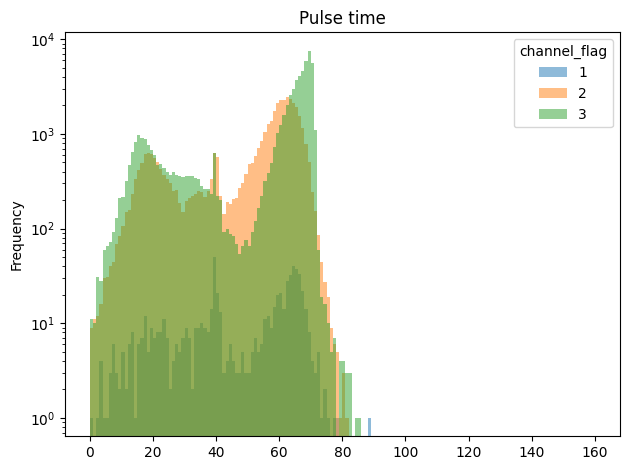

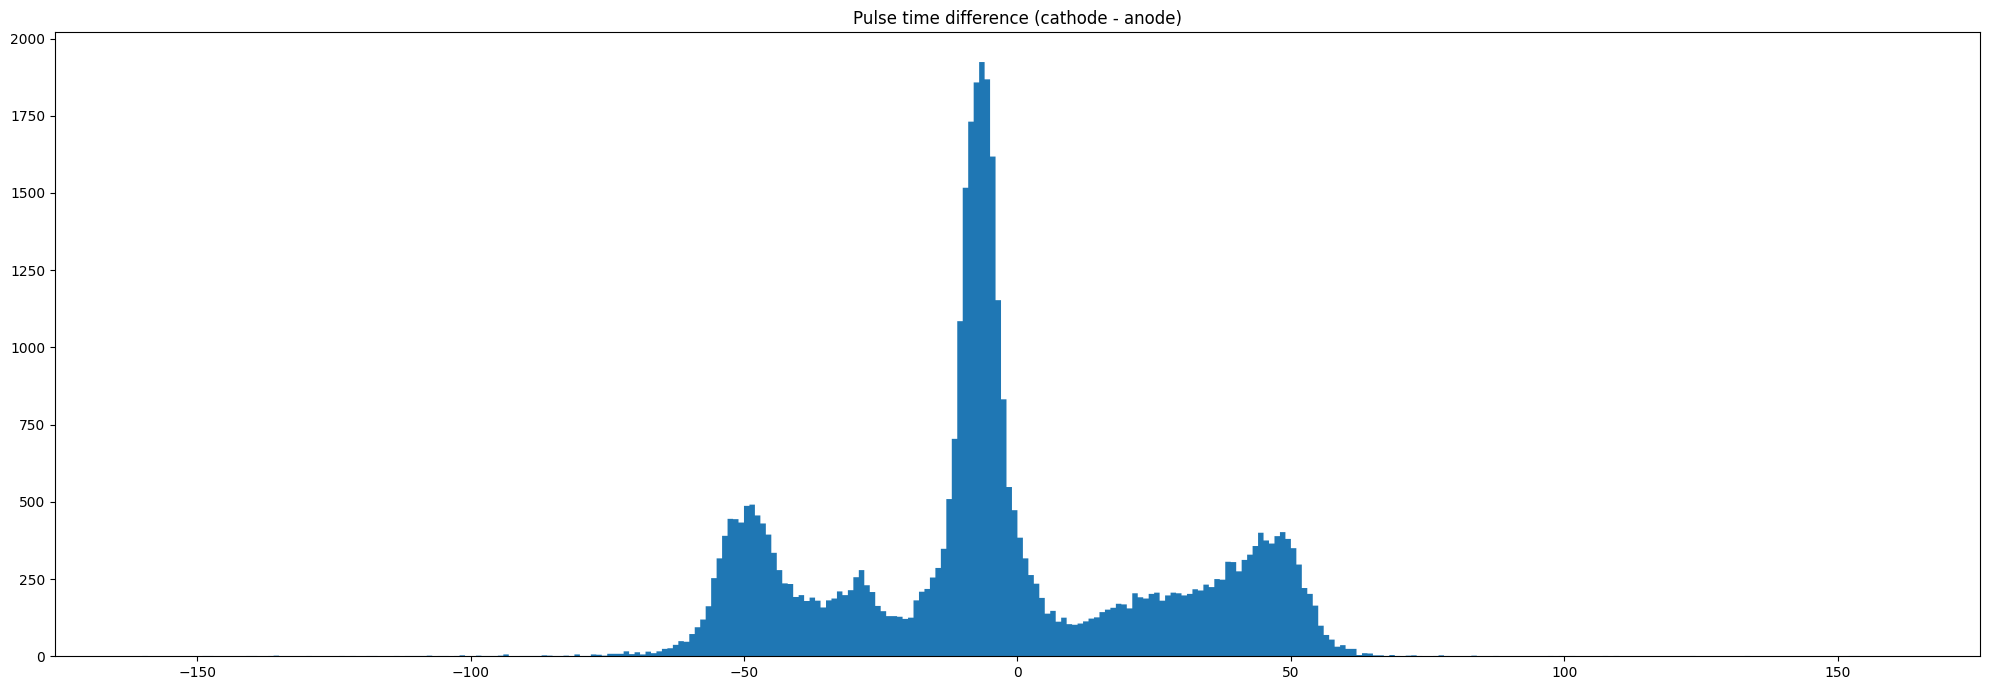

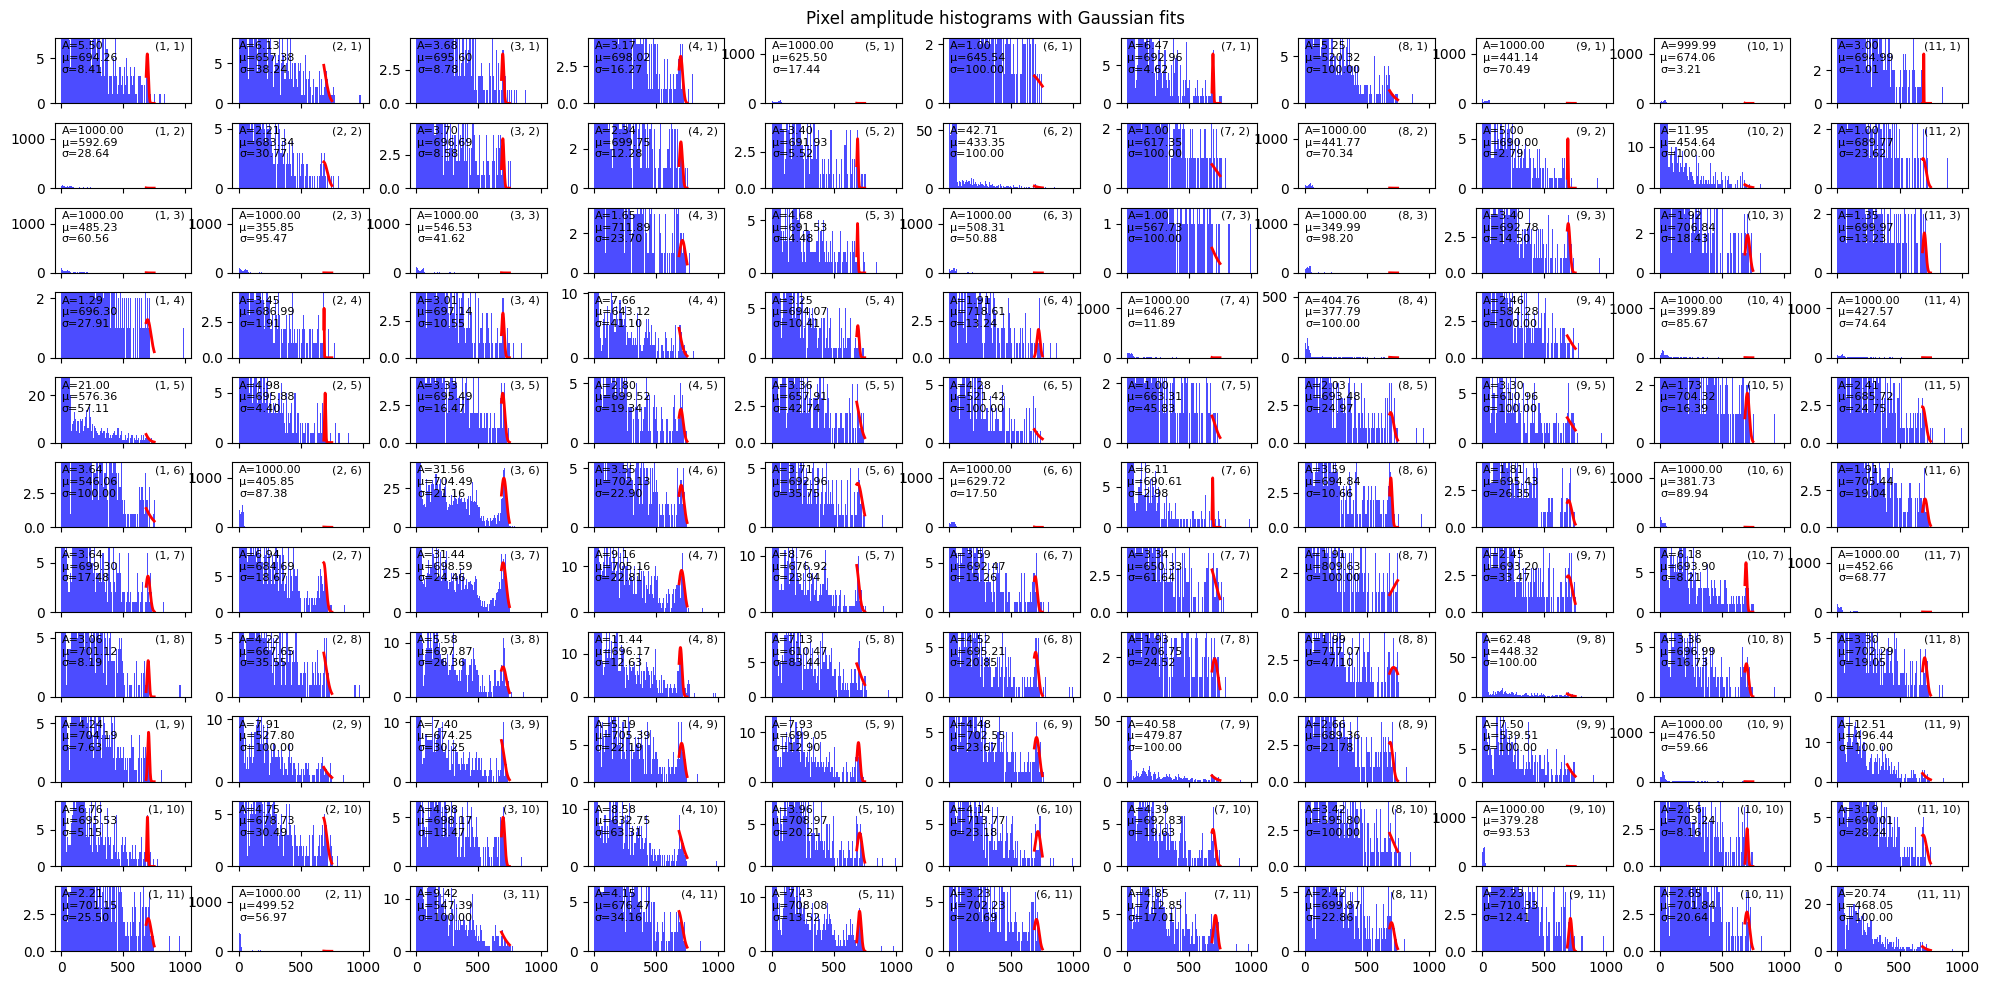

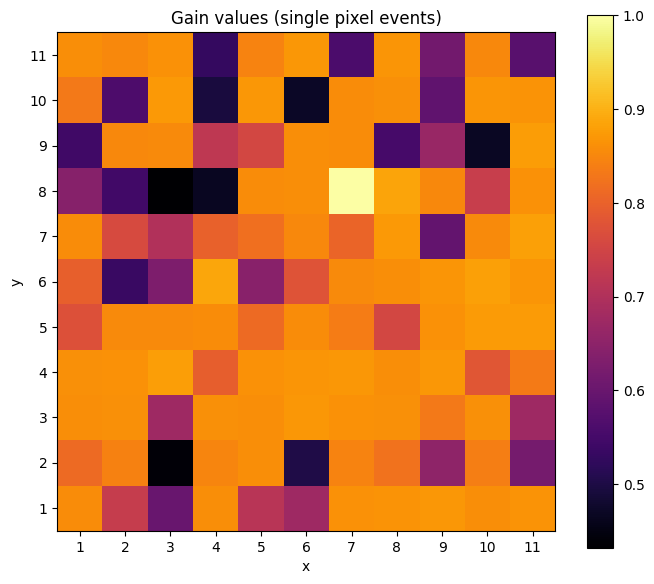

In [23]:
from os.path import join

def stepish_func(x, x0, y0, h, a, b=0, c=0):
    return y0 + h/2*erf((x-x0)*a) + b*x + c*x**2

CFG = yaml.safe_load(open(CONFIG))

class Ideas:
    """ Class for loading, caching, and processing waveform data from binary files. """

    def __init__(self, filename):
        # Generate output filename for caching processed data
        outfilename = Path(filename).stem + ".npy"

        # If a cache file exists, load processed data from it for faster access
        if os.path.exists(outfilename):
            with open(outfilename, "rb") as f:
                self.file_size = np.load(f)        # Total file size
                self.record_size = np.load(f)      # Size of each record
                self.num_records = np.load(f)      # Number of records in file
                self.waveforms = np.load(f)        # Numpy array of waveform data
                self.timestamp = np.load(f)        # Timestamps for each event
                self.x = np.load(f)                # X coordinates
                self.y = np.load(f)                # Y coordinates
                self.channel_flag = np.load(f)     # Channel flags
                print(
                    f'Data loaded from cache "{outfilename}" with shapes\n\twaveforms: {self.waveforms.shape}, timestamp: {self.timestamp.shape}, x: {self.x.shape}, y: {self.y.shape}, channel_flag: {self.channel_flag.shape}'
                )
        else:
            # If cache does not exist, process the binary data file directly
            self.filename = filename
            self.data_type = np.dtype(
                [
                    # Define the binary structure for each record in the file:
                    ("length", ">u2"),         # Two-byte, big-endian unsigned short
                    ("log_type", ">u2"),       # Log type
                    ("packet_count", ">u2"),   # Packet count
                    ("packet_flags", ">u1"),   # Packet flags
                    ("system_number", ">u1"),  # System number
                    ("timestamp", ">u8"),      # Timestamp (8 bytes)
                    # 16 bytes so far
                    ("source_id", ">u1"),      # Source ID
                    ("trig_type", ">u1"),      # Trigger type
                    ("user_status", ">u2"),    # User status
                    ("event_id", ">u4"),       # Event ID
                    ("pps_timestamp", ">u4"),  # PPS timestamp
                    ("channel_flag", ">u1"),   # Channel flag
                    ("cell_pointer", ">u1"),   # Cell pointer
                    ("x_address", ">u1"),      # X address
                    ("y_address", ">u1"),      # Y address
                    # Pipeline Readout Data
                    ("waveforms", (">H", (160,))),  # 160 unsigned shorts (big-endian)
                ]
            )
            self.file_size = os.path.getsize(filename)    # Get file size in bytes
            self.record_size = 32 + 160 * 2               # Calculate size of one record (32 header + 320 waveform = 352)
            self.num_records = self.file_size // self.record_size  # Calculate number of records
            # Create a memory-mapped array for efficient access to large binary file
            self.memmap = np.memmap(filename, dtype=self.data_type, mode="r", shape=(self.num_records))

            # Fix timestamp overflow (timestamps sometimes wrap around)
            prev_timestamp = self.memmap["timestamp"][0]
            overflow_increment = 0
            adjusted_timestamps = np.zeros_like(self.memmap["timestamp"])
            for i, ts in enumerate(self.memmap["timestamp"]):
                if ts < prev_timestamp:
                    overflow_increment += prev_timestamp  # Add overflow increment
                adjusted_timestamps[i] = ts + overflow_increment  # Adjust timestamp
                prev_timestamp = ts

            # Convert data to native byte order for processing
            self.timestamp = adjusted_timestamps.byteswap().view(adjusted_timestamps.dtype.newbyteorder())
            self.x = self.memmap["x_address"].byteswap().view(self.memmap["x_address"].dtype.newbyteorder())
            self.y = self.memmap["y_address"].byteswap().view(self.memmap["y_address"].dtype.newbyteorder())
            self.channel_flag = self.memmap["channel_flag"].byteswap().view(self.memmap["channel_flag"].dtype.newbyteorder())
            # self.cell_pointer = self.memmap["cell_pointer"].byteswap().view(self.memmap["cell_pointer"].dtype.newbyteorder())
            self.waveforms = self.memmap["waveforms"].byteswap().view(self.memmap["waveforms"].dtype.newbyteorder())

            print(
                f'Data loaded from original data file "{filename}" with shapes\n\twaveforms: {self.memmap["waveforms"].shape}, timestamp: {self.timestamp.shape}, x: {self.x.shape}, y: {self.y.shape}, channel_flag: {self.channel_flag.shape}'
            )

            # Save processed arrays to cache file for future fast loading
            with open(outfilename, "wb") as f:
                np.save(f, self.file_size)
                np.save(f, self.record_size)
                np.save(f, self.num_records)
                np.save(f, self.waveforms)
                np.save(f, self.timestamp)
                np.save(f, self.x)
                np.save(f, self.y)
                np.save(f, self.channel_flag)
                print(f'Data saved to cache file "{outfilename}"')

    def pixel_value(self, x, y):
        # Retrieve all waveform data for a specific pixel (address x,y)
        mask = (self.x == x) & (self.y == y)
        return self.waveforms[mask]

# Gaussian function for fitting peaks in histograms
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Function to calculate amplitudes for all events and save results
def amplitudes(filename):
    output_folder = join("output", Path(filename).stem)
    output_file = join(output_folder, "amplitudes.csv")

    single_pixel = CFG["amplitudes"]["single_pixel"]

    if single_pixel:
        output_file = output_file.replace(".csv", "_single_pixel.csv")

    cfg = CFG["amplitudes"]
    wcfg = CFG["waveform"]

    # Use cache if available
    if cfg["enable_cache"] and os.path.exists(output_file):
        print(f'Using cached amplitude file "{output_file}"')
        df = pd.read_csv(output_file)
        return df

    ideas = Ideas(filename)
    df = pd.DataFrame({"timestamp": ideas.timestamp, "x": ideas.x, "y": ideas.y, "channel_flag": ideas.channel_flag})

    if not CFG["general"]["quiet"]:
        print(f"Before filtering: {len(df)} waveform entries")
        print(df.head(n=10))

    # Optionally filter to first N events
    if cfg["n"] is not None:
        df = df.head(cfg["n"])

    # Optionally filter by channel flags
    if cfg["channel_flags"] is not None:
        df = df[df["channel_flag"].isin(cfg["channel_flags"])]

    # Filter for single pixel events if enabled
    if single_pixel:
        print("Filtering single pixel events. This usually takes a while")
        df = df.groupby("timestamp").filter(lambda x: len(x[x.channel_flag == 2]) == 1 and len(x[x.channel_flag == 3]) == 1)

    waveforms = ideas.waveforms[df.index]

    x = np.arange(0, len(waveforms[0]))
    histo = []
    ts = []
    # Loop over all waveforms and calculate amplitude and pulse time
    for w in tqdm(waveforms, desc="Calculating amplitudes"):
        low = np.mean(w[wcfg["anode_low_lim"][0] : wcfg["anode_low_lim"][1]])
        high = np.mean(w[wcfg["anode_high_lim"][0] : wcfg["anode_high_lim"][1]])
        A = high - low
        histo.append(A)

        if A < 100:
            ts.append(np.nan)
            continue

        try:
            popt, pocv = curve_fit(stepish_func, x, w, p0 = (np.nanmean(x)/2, np.min(w), np.max(w) - np.min(w), 1.0, 1.0), maxfev=10000)
        except RuntimeError as e:
            print(f'Failed to fit peak', end=" ")
            print(e)
            ts.append(np.nan)
            continue

        t = popt[0]
        ts.append(t)

    # Store amplitude and pulse time in dataframe
    df["amplitude"] = histo
    df["pulse_time"] = ts

    if not CFG["general"]["quiet"]:
        print(f"After calculation: {len(df)} amplitude entries")
        print(df.head(n=10))

    os.makedirs(output_folder, exist_ok=True)
    df.to_csv(output_file, index=False)

    # Plot histogram of pulse times per channel
    plt.figure(figsize=(20, 7))
    df.pivot(columns="channel_flag", values="pulse_time").plot.hist(bins=160, range=(0, 160), histtype='stepfilled', alpha=0.5)
    plt.title("Pulse time")
    plt.semilogy()
    plt.tight_layout()
    plt.savefig(output_file.replace(".csv", ".pdf"), bbox_inches="tight")

    # Calculate and plot time difference between anode and cathode
    dts = []
    plt.figure(figsize=(20, 7))
    for i, evt in df.groupby("timestamp"):
        n_triggered = len(evt[evt.channel_flag == 3])

        if n_triggered != 1:
            continue

        dt = evt[evt.channel_flag == 2].pulse_time.item() - evt[evt.channel_flag == 3].pulse_time.item()
        dts.append(dt)

    plt.hist(dts, bins=320, range=(-160, 160), histtype='stepfilled')
    plt.title("Pulse time difference (cathode - anode)")
    plt.tight_layout()
    plt.savefig(output_file.replace(".csv", "_time_diff.pdf"), bbox_inches="tight")

    return df

def calibrate(filename: str):
    output_folder = join("output", Path(filename).stem) # Define output_folder here
    output_file = join(output_folder, "calibrated.csv")
    output_calib_file = join(output_folder, "calibration_values.csv")

    single_pixel = CFG["calibration"]["single_pixel"]

    if single_pixel:
        output_file = output_file.replace(".csv", "_single_pixel.csv")
        output_calib_file = output_calib_file.replace(".csv", "_single_pixel.csv")

    cfg = CFG["calibration"]

    if cfg["enable_cache"] and os.path.exists(output_file):
        print(f'Using cached calibrated file "{output_file}"')
        df = pd.read_csv(output_file)
        return df

    df = amplitudes(filename)

    fig, axs = plt.subplots(11, 11, figsize=(20, 10), sharex=True, sharey=False)  # Changed to sharey=False

    if cfg["enable_cache"] and os.path.exists(output_calib_file):
        calibs = pd.read_csv(output_calib_file)
        print(f'Using cached calibration values "{output_calib_file}"')
    else:
        calibs = []
        # First pass: collect all Gaussian peak heights to find maximum
        max_gaussian_height = 0
        gaussian_heights = np.zeros((11, 11))

        for x in range(11):
            for y in range(11):
                pixel_data = df[(df.x == x + 1) & (df.y == y + 1)].amplitude
                n, bins, _ = axs[y, x].hist(
                    pixel_data,
                    bins=(cfg["hist_range_kev"][1] - cfg["hist_range_kev"][0]) // cfg["hist_bin_width_kev"],
                    range=cfg["hist_range_kev"],
                    histtype="stepfilled",
                    alpha=0.7
                )
                try:
                    popt, _ = curve_fit(gaussian, bins[cfg["roi"][0] : cfg["roi"][1]], n[cfg["roi"][0] : cfg["roi"][1]], **cfg["curve_fit_kwargs"])
                    # Calculate maximum height of the Gaussian fit
                    gaussian_max = gaussian(popt[1], *popt)  # Height at mean position
                    gaussian_heights[y, x] = gaussian_max
                    max_gaussian_height = max(max_gaussian_height, gaussian_max)
                except RuntimeError as e:
                    print(f'Failed to fit peak for pixel ({x+1}, {y+1})')
                    gaussian_heights[y, x] = 0
                    continue

        # Second pass: plot with adjusted y-axis limits
        for x in tqdm(range(11), desc="Fitting gaussians"):
            for y in range(11):
                # Clear the previous plot
                axs[y, x].clear()

                pixel_data = df[(df.x == x + 1) & (df.y == y + 1)].amplitude
                n, bins, _ = axs[y, x].hist(
                    pixel_data,
                    bins=(cfg["hist_range_kev"][1] - cfg["hist_range_kev"][0]) // cfg["hist_bin_width_kev"],
                    range=cfg["hist_range_kev"],
                    histtype="stepfilled",
                    alpha=0.7,
                    color='blue',
                    label='Data'
                )

                try:
                    popt, _ = curve_fit(gaussian, bins[cfg["roi"][0] : cfg["roi"][1]], n[cfg["roi"][0] : cfg["roi"][1]], **cfg["curve_fit_kwargs"])

                    x_dense = np.linspace(bins[cfg["roi"][0]], bins[cfg["roi"][1]], 1000)
                    y_gaussian = gaussian(x_dense, *popt)

                    # Plot the Gaussian fit
                    axs[y, x].plot(x_dense, y_gaussian, "r-", linewidth=2, label='Gaussian fit')

                    # Set y-axis limits to show Gaussian clearly + some margin
                    gaussian_max = gaussian_heights[y, x]
                    if gaussian_max > 0:
                        # Set limits to show Gaussian clearly + some margin
                        y_max = max(np.max(n[cfg["roi"][0]:cfg["roi"][1]]), gaussian_max * 1.2)
                        axs[y, x].set_ylim(0, y_max * 1.1)  # 10% margin

                    axs[y, x].text(0.95, 0.95, f"({x+1}, {y+1})", transform=axs[y, x].transAxes, fontsize=8, verticalalignment="top", horizontalalignment="right")
                    axs[y, x].text(0.05, 0.95, f"A={popt[0]:.2f}\nμ={popt[1]:.2f}\nσ={popt[2]:.2f}", transform=axs[y, x].transAxes, fontsize=8, verticalalignment="top")

                    new = pd.DataFrame({"coord": [f"{x+1},{y+1}"], "x": [x + 1], "y": [y + 1], "A": [popt[0]], "mu": [popt[1]], "sigma": [popt[2]]})
                    calibs.append(new)

                except RuntimeError as e:
                    print(f'Failed to fit peak for pixel ({x+1}, {y+1})')
                    axs[y, x].text(0.5, 0.5, "Fit failed", transform=axs[y, x].transAxes,
                                  ha='center', va='center', fontsize=8)
                    continue

        calibs = pd.concat(calibs, ignore_index=True)
        calibs.set_index("coord", inplace=True, drop=True)
        calibs["calib"] = calibs.mu / calibs.mu.max()
        calibs.to_csv(output_calib_file)

    plt.suptitle("Pixel amplitude histograms with Gaussian fits")
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increased spacing for better visibility

    # Rest of your calibration code remains the same...
    df["amplitude_calibrated"] = df["amplitude"]
    for i, row in calibs.iterrows():
        df.loc[(df.x == row.x) & (df.y == row.y), "amplitude_calibrated"] /= row.calib

    df["energy"] = df["amplitude_calibrated"]
    for i, row in calibs.iterrows():
        corrected_mu = row.mu / row.calib
        df.loc[(df.x == row.x) & (df.y == row.y), "energy"] *= cfg["calib_peak_energy"] / corrected_mu

    if not CFG["general"]["quiet"]:
        print(f"Calibration constants:\n{calibs}")
        print(df.head(n=10))

    if CFG["general"]["plot"]:
        plt.figure(figsize=(7, 6))
        plt.imshow(calibs.calib.values.reshape(11, 11), cmap="inferno", origin="lower")
        plt.colorbar()
        plt.title("Gain values" + (" (single pixel events)" if single_pixel else ""))
        plt.xticks(range(11), range(1, 12))
        plt.yticks(range(11), range(1, 12))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.tight_layout()

        plot_filename = join(output_folder, "calibration_values.pdf")
        if single_pixel:
            plot_filename = plot_filename.replace(".pdf", "_single_pixel.pdf")
        plt.savefig(plot_filename, bbox_inches="tight")

    df.to_csv(output_file, index=False)

    return df


calibrate(BINARY_DATA)

# To generate the plots of the events and save as PDFs in the output folder.

In [39]:
# Generate all event plots
# data_loader.generate_event_plots(single_pixel_only=False)

# Or generate only single-pixel events
data_loader.generate_event_plots(single_pixel_only=True)

Generating event plots in output/events/scan_x0.13_y0.06_2025-10-23__11_25_26


Generating event plots:   0%|          | 9/86022 [01:37<258:06:09, 10.80s/it]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7bcafc191940> (for post_execute):


KeyboardInterrupt: 

In [26]:
# Function to calibrate pixel amplitudes, fit Gaussians, and save calibration constants
def calibrate(filename: str):
    output_folder = join("output", Path(filename).stem)
    os.makedirs(output_folder, exist_ok=True)

    output_file = join(output_folder, "calibrated.csv")
    output_calib_file = join(output_folder, "calibration_values.csv")

    single_pixel = CFG["calibration"]["single_pixel"]

    if single_pixel:
        output_file = output_file.replace(".csv", "_single_pixel.csv")
        output_calib_file = output_calib_file.replace(".csv", "_single_pixel.csv")

    cfg = CFG["calibration"]

    # Use cache if available
    if cfg["enable_cache"] and os.path.exists(output_file):
        print(f'Using cached calibrated file "{output_file}"')
        df = pd.read_csv(output_file)
        return df

    df = amplitudes(filename)

    fig, axs = plt.subplots(11, 11, figsize=(20, 10), sharex=True, sharey=True)

    # Use cache for calibration values if available
    if cfg["enable_cache"] and os.path.exists(output_calib_file):
        calibs = pd.read_csv(output_calib_file)
        print(f'Using cached calibration values "{output_calib_file}"')
    else:
        calibs = []
        for x in tqdm(range(11), desc="Fitting gaussians"):
            for y in range(11):
                n, bins, _ = axs[y, x].hist(
                    df[(df.x == x + 1) & (df.y == y + 1)].amplitude,
                    bins=(cfg["hist_range_kev"][1] - cfg["hist_range_kev"][0]) // cfg["hist_bin_width_kev"],
                    range=cfg["hist_range_kev"],
                    histtype="stepfilled",
                )

                try:
                    popt, _ = curve_fit(gaussian, bins[cfg["roi"][0] : cfg["roi"][1]], n[cfg["roi"][0] : cfg["roi"][1]], **cfg["curve_fit_kwargs"])
                except RuntimeError as e:
                    print(f'Failed to fit peak for pixel ({x}, {y})')
                    print(e)
                    pass

                x_dense = np.linspace(bins[cfg["roi"][0]], bins[cfg["roi"][1]], 1000)
                axs[y, x].plot(x_dense, gaussian(x_dense, *popt), "r-")
                axs[y, x].text(0.95, 0.95, f"({x+1}, {y+1})", transform=axs[y, x].transAxes, fontsize=8, verticalalignment="top", horizontalalignment="right")
                axs[y, x].text(0.05, 0.95, f"A={popt[0]:.2f}\nμ={popt[1]:.2f}\nσ={popt[2]:.2f}", transform=axs[y, x].transAxes, fontsize=8, verticalalignment="top")

                new = pd.DataFrame({"coord": [f"{x+1},{y+1}"], "x": [x + 1], "y": [y + 1], "A": [popt[0]], "mu": [popt[1]], "sigma": [popt[2]]})
                calibs.append(new)

        calibs = pd.concat(calibs, ignore_index=True)
        calibs.set_index("coord", inplace=True, drop=True)

        calibs["calib"] = calibs.mu / calibs.mu.max()  # Normalize calibration values

        calibs.to_csv(output_calib_file)

    plt.suptitle("Pixel amplitude histograms")
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

    # Apply calibration to amplitude values
    df["amplitude_calibrated"] = df["amplitude"]
    for i, row in calibs.iterrows():
        df.loc[(df.x == row.x) & (df.y == row.y), "amplitude_calibrated"] /= row.calib

    # Convert calibrated amplitude to energy scale
    df["energy"] = df["amplitude_calibrated"]
    for i, row in calibs.iterrows():
        corrected_mu = row.mu / row.calib
        df.loc[(df.x == row.x) & (df.y == row.y), "energy"] *= cfg["calib_peak_energy"] / corrected_mu

    if not CFG["general"]["quiet"]:
        print(f"Calibration constants:\n{calibs}")
        print(df.head(n=10))

    # Plot calibration map
    if CFG["general"]["plot"]:
        plt.figure(figsize=(7, 6))
        plt.imshow(calibs.calib.values.reshape(11, 11), cmap="inferno", origin="lower")
        plt.colorbar()
        plt.title("Gain values" + (" (single pixel events)" if single_pixel else ""))
        plt.xticks(range(11), range(1, 12))
        plt.yticks(range(11), range(1, 12))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.tight_layout()

        plot_filename = join(output_folder, "calibration_values.pdf")
        if single_pixel:
            plot_filename = plot_filename.replace(".pdf", "_single_pixel.pdf")

        plt.savefig(plot_filename, bbox_inches="tight")

    df.to_csv(output_file, index=False)

    return df


In [27]:
import concurrent.futures

def calculate_pulse_time_simple(w, threshold_ratio=0.5):
    """Faster pulse time detection using threshold crossing"""
    baseline = np.mean(w[:10])  # First 10 samples as baseline
    peak = np.max(w)
    threshold = baseline + threshold_ratio * (peak - baseline)

    # Find where waveform crosses threshold
    above_threshold = w > threshold
    if not np.any(above_threshold):
        return np.nan

    # Find first crossing
    cross_idx = np.argmax(above_threshold)

    # Linear interpolation for sub-sample accuracy
    if cross_idx > 0:
        t0 = cross_idx - 1
        t1 = cross_idx
        y0 = w[t0] - threshold
        y1 = w[t1] - threshold
        if y0 != y1:
            fractional = -y0 / (y1 - y0)
            return t0 + fractional
    return cross_idx


import concurrent.futures


def fit_waveform(args):
    """Helper function to fit a single waveform - modified for ProcessPoolExecutor"""
    w, x, p0 = args
    try:
        popt, _ = curve_fit(stepish_func, x, w, p0=p0, maxfev=10000)
        return popt[0]  # Return the pulse time (x0)
    except Exception as e:
        return np.nan

def stepish_func(x, x0, y0, h, a, b=0, c=0):
    """Step function used in the existing pipeline for pulse time fitting"""
    return y0 + h/2 * erf((x - x0) * a) + b * x + c * x ** 2

class IdeasDataLoader:
    """Wrapper around the existing Ideas class to load and preprocess data"""

    def __init__(self, bin_file_path, config_path=CONFIG):
        self.bin_file_path = bin_file_path
        self.config = yaml.safe_load(open(config_path))

        # Load data using the existing pattern
        self.load_binary_data()
        self.preprocess_events()

    def load_binary_data(self):
        """Load binary data using the existing data structure"""
        filename = self.bin_file_path
        outfilename = Path(filename).stem + ".npy"

        if os.path.exists(outfilename):
            print(f"Loading cached data from {outfilename}")
            with open(outfilename, "rb") as f:
                file_size = np.load(f)
                record_size = np.load(f)
                num_records = np.load(f)
                waveforms = np.load(f)
                timestamp = np.load(f)
                x = np.load(f)
                y = np.load(f)
                channel_flag = np.load(f)
        else:
            # Create numpy memmap from binary file (same as original code)
            data_type = np.dtype([
                ("length", ">u2"), ("log_type", ">u2"), ("packet_count", ">u2"),
                ("packet_flags", ">u1"), ("system_number", ">u1"), ("timestamp", ">u8"),
                ("source_id", ">u1"), ("trig_type", ">u1"), ("user_status", ">u2"),
                ("event_id", ">u4"), ("pps_timestamp", ">u4"), ("channel_flag", ">u1"),
                ("cell_pointer", ">u1"), ("x_address", ">u1"), ("y_address", ">u1"),
                ("waveforms", (">H", (160,))),
            ])

            file_size = os.path.getsize(filename)
            record_size = 32 + 160 * 2  # 352 bytes per record
            num_records = file_size // record_size
            memmap = np.memmap(filename, dtype=data_type, mode="r", shape=(num_records))

            # Fix timestamp overflow (same as original)
            prev_timestamp = memmap["timestamp"][0]
            overflow_increment = 0
            adjusted_timestamps = np.zeros_like(memmap["timestamp"])
            for i, ts in enumerate(memmap["timestamp"]):
                if ts < prev_timestamp:
                    overflow_increment += prev_timestamp
                adjusted_timestamps[i] = ts + overflow_increment
                prev_timestamp = ts

            waveforms = memmap["waveforms"].byteswap().view(memmap["waveforms"].dtype.newbyteorder())
            timestamp = adjusted_timestamps.byteswap().view(adjusted_timestamps.dtype.newbyteorder())
            x = memmap["x_address"].byteswap().view(memmap["x_address"].dtype.newbyteorder())
            y = memmap["y_address"].byteswap().view(memmap["y_address"].dtype.newbyteorder())
            channel_flag = memmap["channel_flag"].byteswap().view(memmap["channel_flag"].dtype.newbyteorder())

            # Save to cache
            with open(outfilename, "wb") as f:
                np.save(f, file_size)
                np.save(f, record_size)
                np.save(f, num_records)
                np.save(f, waveforms)
                np.save(f, timestamp)
                np.save(f, x)
                np.save(f, y)
                np.save(f, channel_flag)

        self.waveforms = waveforms
        self.timestamps = timestamp
        self.x_coords = x
        self.y_coords = y
        self.channel_flags = channel_flag

        print(f"Loaded {len(self.waveforms)} waveform records")
        print(f"Data shapes - waveforms: {waveforms.shape}, timestamps: {timestamp.shape}")

    def preprocess_events(self):
        """Group data by timestamp to form complete events"""
        # Create DataFrame for easy grouping
        self.df = pd.DataFrame({
            'timestamp': self.timestamps,
            'x': self.x_coords,
            'y': self.y_coords,
            'channel_flag': self.channel_flags
        })

        # Group by timestamp to get complete events
        self.event_groups = self.df.groupby('timestamp')
        print(f"Found {len(self.event_groups)} unique events")


    def calculate_ground_truth_parallel(self):
      print("Calculating ground truth...")
      wcfg = self.config['waveform']

      amplitudes = []
      pulse_times = []
      event_indices = []
      pixel_types = []

      print("Processing events...")
      for timestamp, group_df in tqdm(self.event_groups, total=len(self.event_groups)):
          group_waveforms = self.waveforms[group_df.index]

          for idx, (row_idx, row) in enumerate(group_df.iterrows()):
              w = group_waveforms[idx]

              if row.channel_flag == 1:  # Anode
                  low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
                  high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
                  amplitude = high - low

                  pulse_time = calculate_pulse_time_simple(w, 0.3)  # 30% threshold

                  is_main = self.is_main_event(group_df, row.x, row.y)
                  pixel_type = 1 if is_main else 2

              elif row.channel_flag == 0:  # Cathode
                  low = np.mean(w[wcfg["cathode_low_lim"][0]:wcfg["cathode_high_lim"][1]])
                  high = np.mean(w[wcfg["cathode_high_lim"][0]:wcfg["cathode_high_lim"][1]])
                  amplitude = high - low

                  pulse_time = calculate_pulse_time_simple(w, 0.3)
                  pixel_type = 0
              else:
                  continue

              amplitudes.append(amplitude)
              pulse_times.append(pulse_time)
              event_indices.append(row_idx)
              pixel_types.append(pixel_type)

      self.ground_truth_df = pd.DataFrame({
          'original_index': event_indices,
          'amplitude': amplitudes,
          'pulse_time': pulse_times,
          'pixel_type': pixel_types
      })

      print(f"Completed in seconds - {len(self.ground_truth_df)} events")


    def is_main_event(self, event_df, x, y):
        """Determine if this anode is the main event in its timestamp group"""
        anodes = event_df[event_df.channel_flag == 1]
        if len(anodes) == 1:
            return True  # Only one anode = main event

        # For multiple anodes, use amplitude to determine main event
        # This is a heuristic - will be improved with the NN
        amplitudes = []
        for idx, row in anodes.iterrows():
            w = self.waveforms[idx]
            low = np.mean(w[self.config['waveform']["anode_low_lim"][0]:self.config['waveform']["anode_low_lim"][1]])
            high = np.mean(w[self.config['waveform']["anode_high_lim"][0]:self.config['waveform']["anode_high_lim"][1]])
            amplitudes.append(high - low)

        max_amp_idx = np.argmax(amplitudes)
        main_anode = anodes.iloc[max_amp_idx]
        return main_anode.x == x and main_anode.y == y

In [28]:
# Initialize data loader with .bin file
print("Loading detector data...")
data_loader = IdeasDataLoader(BINARY_DATA)

# Calculate ground truth using existing pipeline
data_loader.calculate_ground_truth_parallel()

# Show data summary
print("\nData Summary:")
print(f"Total waveforms: {len(data_loader.waveforms)}")
print(f"Unique events: {len(data_loader.event_groups)}")
print(f"Ground truth samples: {len(data_loader.ground_truth_df)}")

Loading detector data...
Loading cached data from scan_x0.13_y0.06_2025-10-23__11_25_26.npy
Loaded 947771 waveform records
Data shapes - waveforms: (947771, 160), timestamps: (947771,)
Found 86022 unique events
Calculating ground truth...
Processing events...


100%|██████████| 86022/86022 [15:03<00:00, 95.24it/s] 


Completed in seconds - 753348 events

Data Summary:
Total waveforms: 947771
Unique events: 86022
Ground truth samples: 753348


**Calculate ground truth - calculate_ground_truth_parallel():**

For each event (grouped by timestamp):

1.Loops through every pixel (channel) involved in that event.

2.Finds the pulse amplitude by subtracting the mean of a “low” window from a “high” window in the waveform. (This measures how strong the pulse is.)

3.Finds the pulse time → by using calculate_pulse_time_simple(w, 0.3), which finds when the waveform crosses 30% of its peak height. (This approximates the signal arrival time.)

4.Labels the pixel as main anode, secondary anode, or cathode, via pixel_type.

5.Stores all this in a new DataFrame (self.ground_truth_df).

In [30]:
import concurrent.futures

def calculate_pulse_time_simple(w, threshold_ratio=0.5):
    """Faster pulse time detection using threshold crossing"""
    baseline = np.mean(w[:10])  # First 10 samples as baseline
    peak = np.max(w)
    threshold = baseline + threshold_ratio * (peak - baseline)

    # Find where waveform crosses threshold
    above_threshold = w > threshold
    if not np.any(above_threshold):
        return np.nan

    # Find first crossing
    cross_idx = np.argmax(above_threshold)

    # Linear interpolation for sub-sample accuracy
    if cross_idx > 0:
        t0 = cross_idx - 1
        t1 = cross_idx
        y0 = w[t0] - threshold
        y1 = w[t1] - threshold
        if y0 != y1:
            fractional = -y0 / (y1 - y0)
            return t0 + fractional
    return cross_idx

def fit_waveform(args):
    """Helper function to fit a single waveform - modified for ProcessPoolExecutor"""
    w, x, p0 = args
    try:
        popt, _ = curve_fit(stepish_func, x, w, p0=p0, maxfev=10000)
        return popt[0]  # Return the pulse time (x0)
    except Exception as e:
        return np.nan

def stepish_func(x, x0, y0, h, a, b=0, c=0):
    """Step function used in the existing pipeline for pulse time fitting"""
    return y0 + h/2 * erf((x - x0) * a) + b * x + c * x ** 2



class Ideas:
    """Wrapper around the existing Ideas class to load and preprocess data"""

    def __init__(self, bin_file_path, config_path=CONFIG):
        self.bin_file_path = bin_file_path
        self.config = yaml.safe_load(open(config_path))

        # Load data using the existing pattern
        self.load_binary_data()
        self.preprocess_events()

    def load_binary_data(self):
        """Load binary data using the existing data structure"""
        filename = self.bin_file_path
        outfilename = Path(filename).stem + ".npy"

        if os.path.exists(outfilename):
            print(f"Loading cached data from {outfilename}")
            with open(outfilename, "rb") as f:
                file_size = np.load(f)
                record_size = np.load(f)
                num_records = np.load(f)
                waveforms = np.load(f)
                timestamp = np.load(f)
                x = np.load(f)
                y = np.load(f)
                channel_flag = np.load(f)
        else:
            # Create numpy memmap from binary file (same as original code)
            data_type = np.dtype([
                ("length", ">u2"), ("log_type", ">u2"), ("packet_count", ">u2"),
                ("packet_flags", ">u1"), ("system_number", ">u1"), ("timestamp", ">u8"),
                ("source_id", ">u1"), ("trig_type", ">u1"), ("user_status", ">u2"),
                ("event_id", ">u4"), ("pps_timestamp", ">u4"), ("channel_flag", ">u1"),
                ("cell_pointer", ">u1"), ("x_address", ">u1"), ("y_address", ">u1"),
                ("waveforms", (">H", (160,))),
            ])

            file_size = os.path.getsize(filename)
            record_size = 32 + 160 * 2  # 352 bytes per record
            num_records = file_size // record_size
            memmap = np.memmap(filename, dtype=data_type, mode="r", shape=(num_records))

            # Fix timestamp overflow (same as original)
            prev_timestamp = memmap["timestamp"][0]
            overflow_increment = 0
            adjusted_timestamps = np.zeros_like(memmap["timestamp"])
            for i, ts in enumerate(memmap["timestamp"]):
                if ts < prev_timestamp:
                    overflow_increment += prev_timestamp
                adjusted_timestamps[i] = ts + overflow_increment
                prev_timestamp = ts

            waveforms = memmap["waveforms"].byteswap().view(memmap["waveforms"].dtype.newbyteorder())
            timestamp = adjusted_timestamps.byteswap().view(adjusted_timestamps.dtype.newbyteorder())
            x = memmap["x_address"].byteswap().view(memmap["x_address"].dtype.newbyteorder())
            y = memmap["y_address"].byteswap().view(memmap["y_address"].dtype.newbyteorder())
            channel_flag = memmap["channel_flag"].byteswap().view(memmap["channel_flag"].dtype.newbyteorder())

            # Save to cache
            with open(outfilename, "wb") as f:
                np.save(f, file_size)
                np.save(f, record_size)
                np.save(f, num_records)
                np.save(f, waveforms)
                np.save(f, timestamp)
                np.save(f, x)
                np.save(f, y)
                np.save(f, channel_flag)

        self.waveforms = waveforms
        self.timestamps = timestamp
        self.x_coords = x
        self.y_coords = y
        self.channel_flags = channel_flag

        print(f"Loaded {len(self.waveforms)} waveform records")
        print(f"Data shapes - waveforms: {waveforms.shape}, timestamps: {timestamp.shape}")

    def preprocess_events(self):
        """Group data by timestamp to form complete events"""
        # Create DataFrame for easy grouping
        self.df = pd.DataFrame({
            'timestamp': self.timestamps,
            'x': self.x_coords,
            'y': self.y_coords,
            'channel_flag': self.channel_flags
        })

        # Group by timestamp to get complete events
        self.event_groups = self.df.groupby('timestamp')
        print(f"Found {len(self.event_groups)} unique events")


    def calculate_pulse_time_simple(self, w, threshold_ratio=0.3):
        """Instance method version of pulse time calculation"""
        baseline = np.mean(w[:10])
        peak = np.max(w)
        threshold = baseline + threshold_ratio * (peak - baseline)

        above_threshold = w > threshold
        if not np.any(above_threshold):
            return np.nan

        cross_idx = np.argmax(above_threshold)

        if cross_idx > 0:
            t0 = cross_idx - 1
            t1 = cross_idx
            y0 = w[t0] - threshold
            y1 = w[t1] - threshold
            if y0 != y1:
                fractional = -y0 / (y1 - y0)
                return t0 + fractional
        return cross_idx


    def calculate_ground_truth_parallel(self):
      print("Calculating ground truth...")
      wcfg = self.config['waveform']

      amplitudes = []
      pulse_times = []
      event_indices = []
      pixel_types = []

      print("Processing events...")
      for timestamp, group_df in tqdm(self.event_groups, total=len(self.event_groups)):
          group_waveforms = self.waveforms[group_df.index]

          for idx, (row_idx, row) in enumerate(group_df.iterrows()):
              w = group_waveforms[idx]

              if row.channel_flag == 1:  # Anode
                  low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
                  high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
                  amplitude = high - low

                  pulse_time = calculate_pulse_time_simple(w, 0.3)  # 30% threshold

                  is_main = self.is_main_event(group_df, row.x, row.y)
                  pixel_type = 1 if is_main else 2

              elif row.channel_flag == 0:  # Cathode
                  low = np.mean(w[wcfg["cathode_low_lim"][0]:wcfg["cathode_high_lim"][1]])
                  high = np.mean(w[wcfg["cathode_high_lim"][0]:wcfg["cathode_high_lim"][1]])
                  amplitude = high - low

                  pulse_time = calculate_pulse_time_simple(w, 0.3)
                  pixel_type = 0
              else:
                  continue

              amplitudes.append(amplitude)
              pulse_times.append(pulse_time)
              event_indices.append(row_idx)
              pixel_types.append(pixel_type)

      self.ground_truth_df = pd.DataFrame({
          'original_index': event_indices,
          'amplitude': amplitudes,
          'pulse_time': pulse_times,
          'pixel_type': pixel_types
      })

      print(f"Completed in seconds - {len(self.ground_truth_df)} events")


    def is_main_event(self, event_df, x, y):
        """Determine if this anode is the main event in its timestamp group"""
        anodes = event_df[event_df.channel_flag == 1]
        if len(anodes) == 1:
            return True  # Only one anode = main event

        # For multiple anodes, use amplitude to determine main event
        # This is a heuristic - will be improved with the NN
        amplitudes = []
        for idx, row in anodes.iterrows():
            w = self.waveforms[idx]
            low = np.mean(w[self.config['waveform']["anode_low_lim"][0]:self.config['waveform']["anode_low_lim"][1]])
            high = np.mean(w[self.config['waveform']["anode_high_lim"][0]:self.config['waveform']["anode_high_lim"][1]])
            amplitudes.append(high - low)

        max_amp_idx = np.argmax(amplitudes)
        main_anode = anodes.iloc[max_amp_idx]
        return main_anode.x == x and main_anode.y == y


    def generate_event_plots(self, output_dir="output/events", single_pixel_only=False):
        """Generate event PDF plots - equivalent to 'events' command. Saves them in the events folder"""
        output_folder = Path(output_dir) / Path(self.bin_file_path).stem
        output_folder.mkdir(parents=True, exist_ok=True)

        wcfg = self.config['waveform']

        print(f"Generating event plots in {output_folder}")

        for timestamp, event_df in tqdm(self.event_groups, desc="Generating event plots"):
            output_filename = output_folder / f"event_{timestamp}.pdf"

            if output_filename.exists():
                print(f"Not recreating {output_filename}")
                continue

            # Filter for single-pixel events if requested
            if single_pixel_only:
                n_triggered = len(event_df[event_df.channel_flag == 3])
                if n_triggered != 1:
                    continue

            # Create the 11x12 grid (detector layout)
            fig, axs = plt.subplots(11, 12, figsize=(20, 10), sharex=True, sharey=True)

            # Hide unused subplots
            for row in range(11):
                if row <= 1:  # Adjust based on actual layout
                    continue
                axs[row, 11].set_visible(False)

            fig.suptitle(f"Timestamp {timestamp}")

            amplitude_cathode = None
            t_anode = None
            t_cathode = None

            # Plot each pixel in the event
            for idx, (row_idx, row) in enumerate(event_df.iterrows()):
                w = self.waveforms[row_idx]

                if row.channel_flag == 0:
                  continue

                # Determine subplot position
                if 255 in (row.x, row.y):  # Special pixels
                    ax = axs[0, 11]
                else:
                    ax = axs[11 - int(row.y), int(row.x) - 1]

                # Pixel coordinate label
                ax.text(0.95, 0.05, f"({row.x}, {row.y})", transform=ax.transAxes,
                      fontsize=8, verticalalignment="bottom", horizontalalignment="right")

                # Color coding by channel type
                colors = {0: "tab:red", 1: "tab:blue", 2: "tab:purple", 3: "tab:green"}
                ax.plot(w, colors[row.channel_flag], alpha=0.5)

                # Calculate amplitude and timing
                if row.channel_flag == 1:  # Anode
                    low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
                    high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
                    amplitude = high - low

                    # Mark amplitude regions
                    ax.plot([wcfg["anode_low_lim"][0], wcfg["anode_low_lim"][1]], [low, low], "magenta")
                    ax.plot([wcfg["anode_high_lim"][0], wcfg["anode_high_lim"][1]], [high, high], "magenta")

                    # Calculate pulse time
                    t_anode = self.calculate_pulse_time_simple(w)
                    ax.text(0.05, 0.95, f"A={amplitude:.2f}\nt={t_anode:.0f}",
                          transform=ax.transAxes, fontsize=8, verticalalignment="top")

                elif row.channel_flag == 0:  # Cathode
                    low = np.mean(w[wcfg["cathode_low_lim"][0]:wcfg["cathode_low_lim"][1]])
                    high = np.mean(w[wcfg["cathode_high_lim"][0]:wcfg["cathode_high_lim"][1]])

                    if amplitude_cathode is not None:
                        print("Multiple cathode events in one timestamp")
                        continue

                    amplitude_cathode = high - low
                    ax.plot([wcfg["cathode_low_lim"][0], wcfg["cathode_low_lim"][1]], [low, low], "magenta")
                    ax.plot([wcfg["cathode_high_lim"][0], wcfg["cathode_high_lim"][1]], [high, high], "magenta")

                    t_cathode = self.calculate_pulse_time_simple(w)
                    ax.text(0.05, 0.95, f"A={amplitude_cathode:.2f}\nt={t_cathode:.0f}",
                          transform=ax.transAxes, fontsize=8, verticalalignment="top")

            # Add event statistics
            if t_cathode is not None and t_anode is not None:
                nums = event_df.groupby("channel_flag").size()
                dt = t_cathode - t_anode

                info = "channel_flag amounts\n" + "\n".join([f"{k}: {v}" for k, v in nums.items()])
                info += f"\ndt = {dt:.0f} ns"

                axs[1, 11].text(0.5, 0.5, info, transform=axs[1, 11].transAxes,
                              fontsize=8, verticalalignment="center", horizontalalignment="center")
                axs[1, 11].axis("off")

            plt.tight_layout()
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(output_filename, bbox_inches="tight")
            plt.close()

        print(f"Event plot generation complete")

In [31]:
# Initialize data loader with .bin file
print("Loading detector data...\n")
data_loader = Ideas(BINARY_DATA)

Loading detector data...

Loading cached data from scan_x0.13_y0.06_2025-10-23__11_25_26.npy
Loaded 947771 waveform records
Data shapes - waveforms: (947771, 160), timestamps: (947771,)
Found 86022 unique events


In [32]:
# Data summary
print("--- DATA SUMMARY ---")
print(f"Total waveforms: {len(data_loader.waveforms)}")
print(f"Unique events: {len(data_loader.event_groups)}")

--- DATA SUMMARY ---
Total waveforms: 947771
Unique events: 86022


In [33]:
# Calculate ground truth using existing pipeline
data_loader.calculate_ground_truth_parallel()

print(f"Ground truth samples: {len(data_loader.ground_truth_df)}")

Calculating ground truth...
Processing events...


100%|██████████| 86022/86022 [14:24<00:00, 99.46it/s]


Completed in seconds - 753348 events
Ground truth samples: 753348


# **2.  Bin Data Exploration**
i. Overall Data Quality Report

In [34]:
def data_quality_report(data_loader):
    """Comprehensive data quality assessment"""
    print("=== DATA QUALITY REPORT ===")

    # Event statistics
    total_events = len(data_loader.event_groups)
    pixel_counts = [len(group) for _, group in data_loader.event_groups]

    print(f"Total events: {total_events}")
    print(f"Events with 1 pixel: {sum(1 for x in pixel_counts if x == 1)}")
    print(f"Events with 3-9 pixels: {sum(1 for x in pixel_counts if 3 <= x <= 9)}")
    print(f"Events with 10+ pixels: {sum(1 for x in pixel_counts if x >= 10)}")

    # Signal quality
    amplitudes = data_loader.ground_truth_df['amplitude'].dropna()
    print(f"Amplitude range: {amplitudes.min():.1f} - {amplitudes.max():.1f}")
    print(f"Mean amplitude: {amplitudes.mean():.1f} ± {amplitudes.std():.1f}")

    # Coordinate analysis
    valid_coords = data_loader.df[(data_loader.df.x < 11) & (data_loader.df.y < 11)]
    print(f"Valid coordinates: {len(valid_coords)} / {len(data_loader.df)}")

data_quality_report(data_loader)

=== DATA QUALITY REPORT ===
Total events: 86022
Events with 1 pixel: 0
Events with 3-9 pixels: 25238
Events with 10+ pixels: 60784
Amplitude range: -393.9 - 6659.7
Mean amplitude: 4.9 ± 65.4
Valid coordinates: 759495 / 947771


ii. 2D imagae generation from the Bin file

Debugging coordinate mapping...
Coordinate mapping debug:
Raw -> Grid mapping: (x, y) -> [11 - y, x - 1]

Raw: (255, 255) -> Grid: (0, 11) - SPECIAL
Raw: ( 11,   8) -> Grid: [3, 10]
Raw: ( 11,   7) -> Grid: [4, 10]
Raw: ( 10,   8) -> Grid: [3, 9]
Raw: ( 11,   9) -> Grid: [2, 10]
Raw: ( 10,   7) -> Grid: [4, 9]
Raw: ( 10,   9) -> Grid: [2, 9]
Raw: ( 10,   8) -> Grid: [3, 9]
Raw: ( 10,   7) -> Grid: [4, 9]
Raw: (  9,   8) -> Grid: [3, 8]
Raw: ( 11,   8) -> Grid: [3, 10]
Raw: ( 10,   9) -> Grid: [2, 9]
Raw: (  9,   7) -> Grid: [4, 8]
Raw: ( 11,   7) -> Grid: [4, 10]
Raw: (  9,   9) -> Grid: [2, 8]
Raw: ( 11,   9) -> Grid: [2, 10]

Creating EXACT replica visualizations...
Visualizing event with timestamp 789655439
Event has 16 triggered pixels


/tmp/ipython-input-3043370454.py:112: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(stepish_func, x, w,


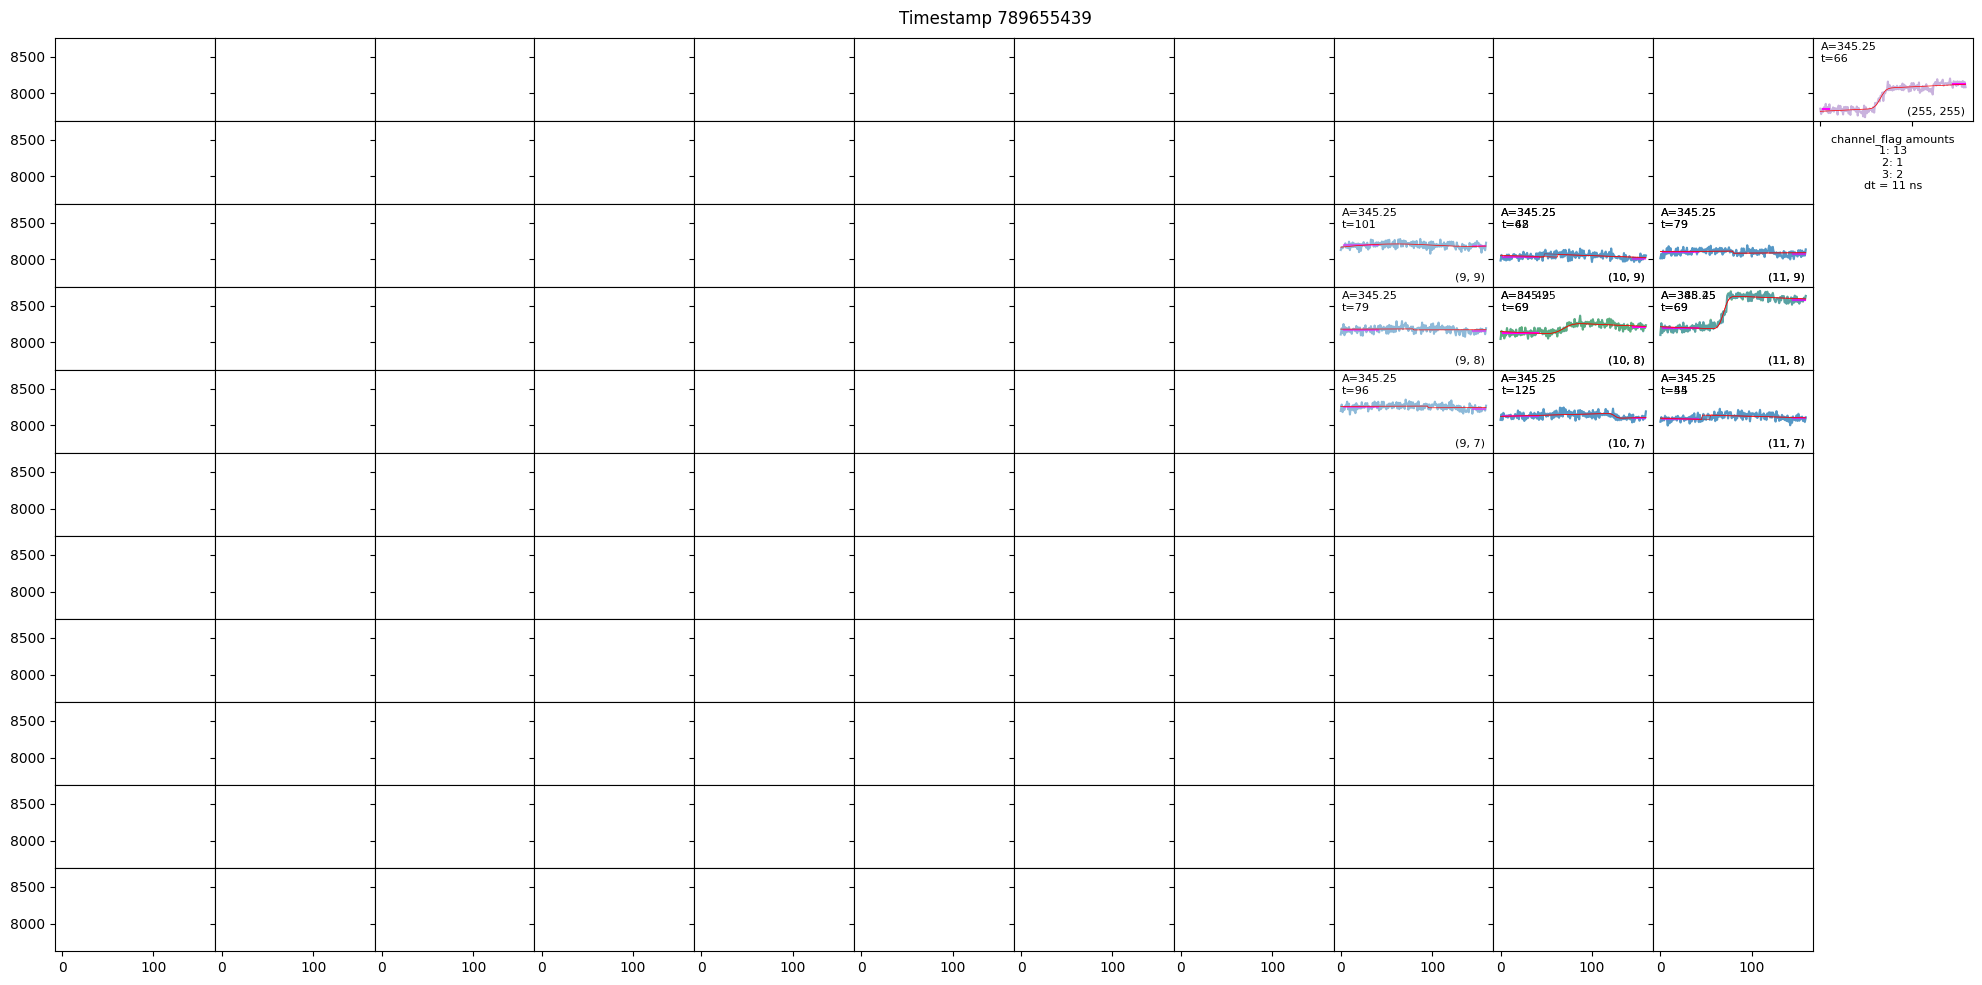

--------------------------------------------------
Visualizing event with timestamp 791050127
Event has 10 triggered pixels


/tmp/ipython-input-3043370454.py:112: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(stepish_func, x, w,


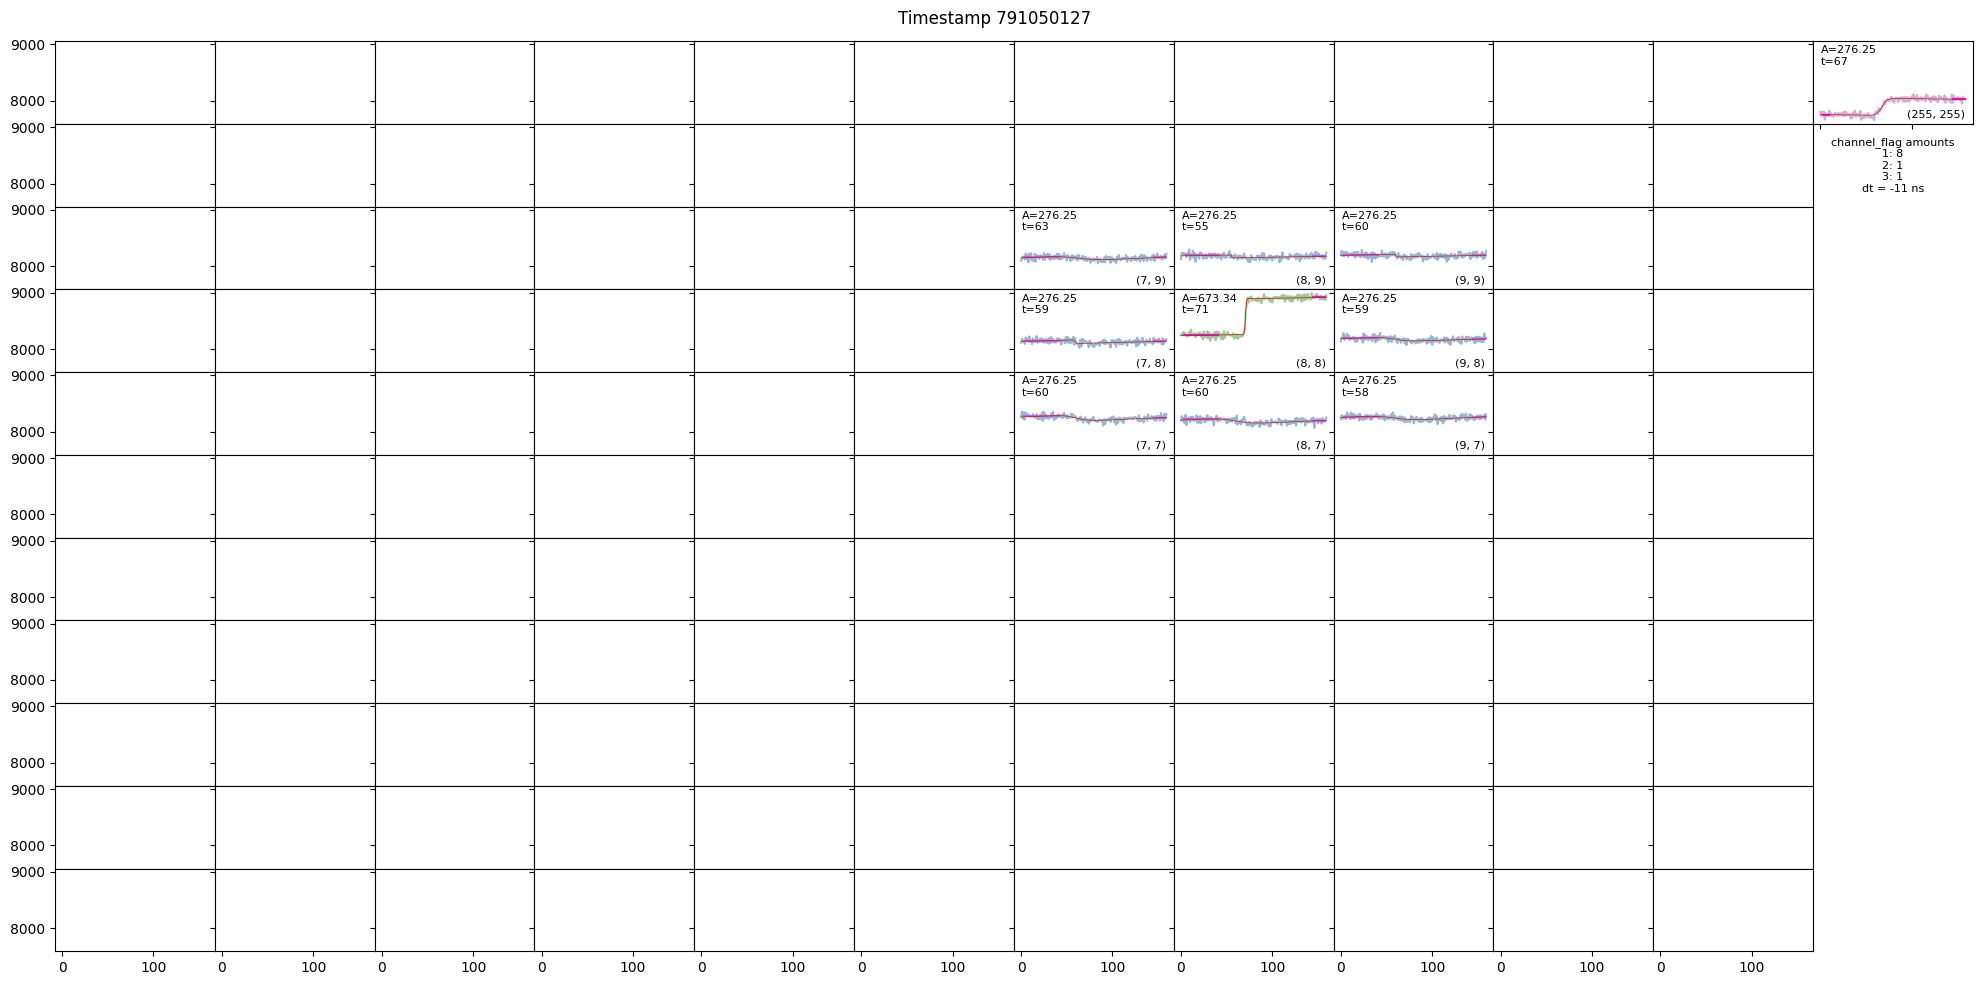

--------------------------------------------------
Visualizing event with timestamp 793646525
Event has 10 triggered pixels


/tmp/ipython-input-3043370454.py:112: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(stepish_func, x, w,


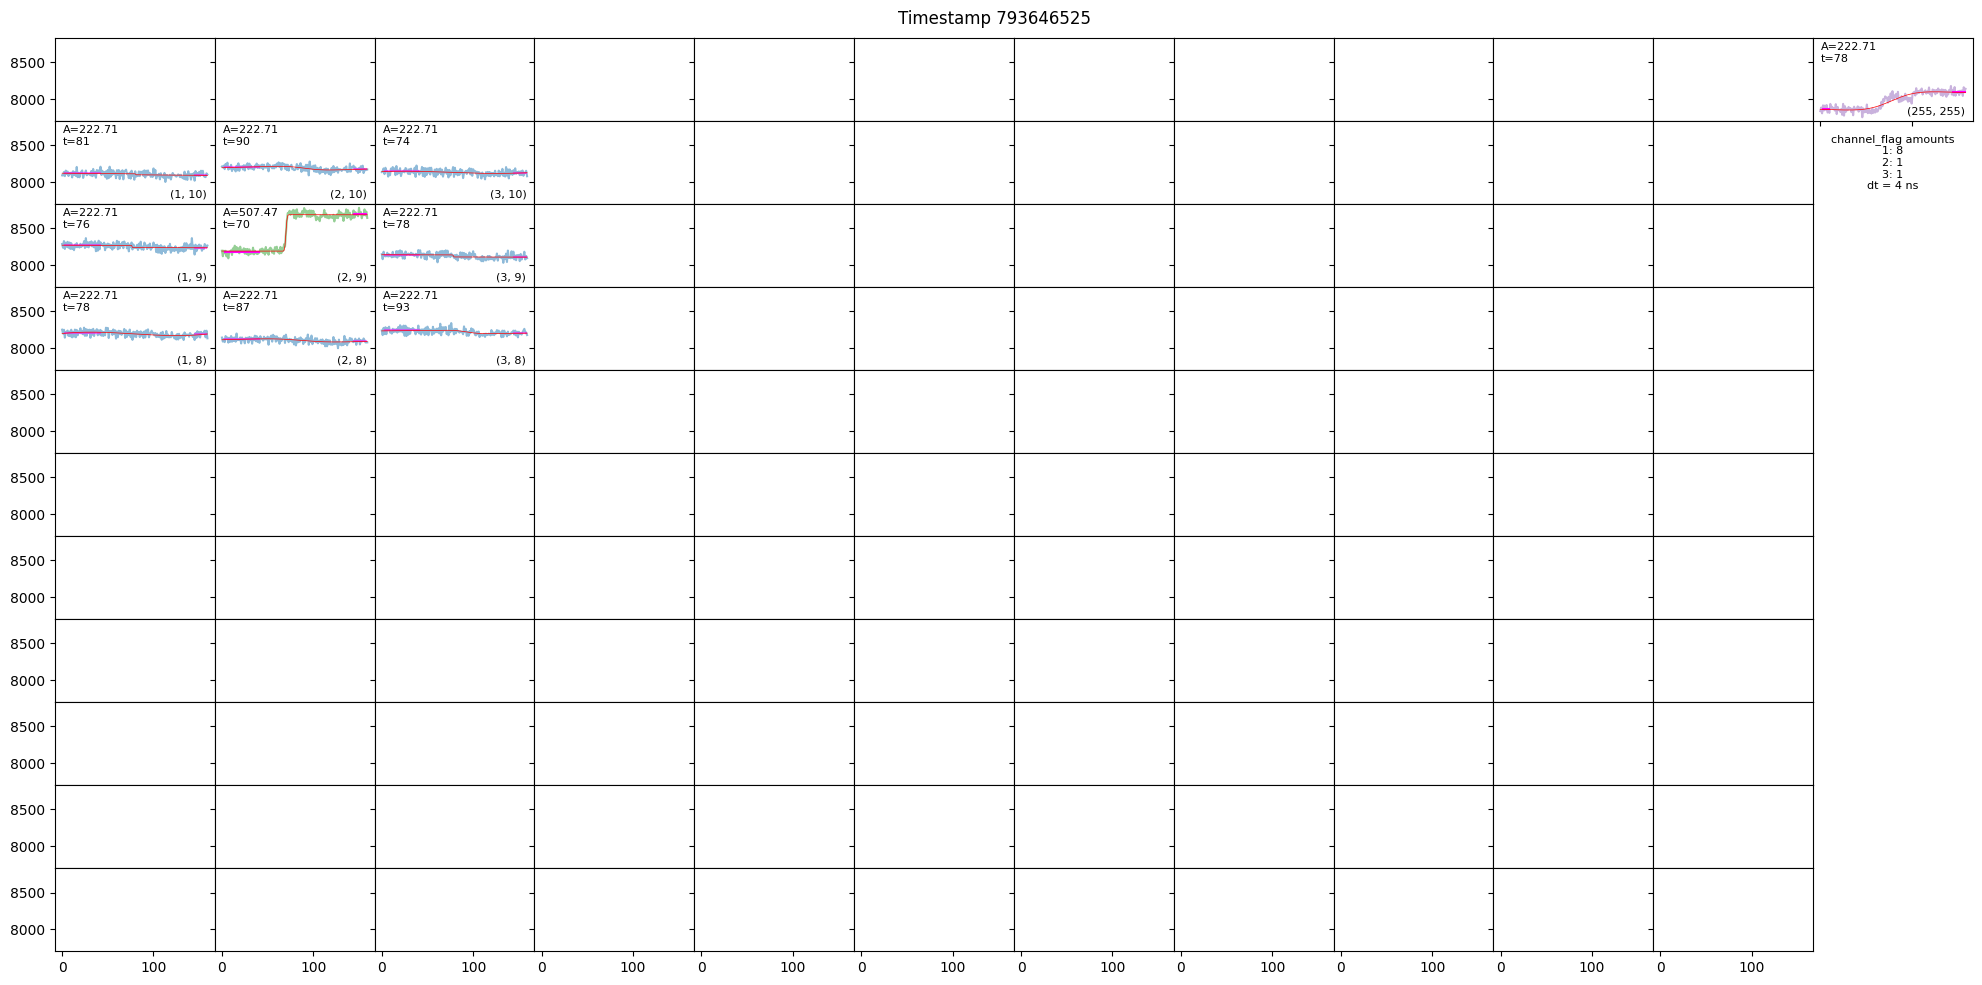

--------------------------------------------------


In [35]:
def visualize_event_exact_match(data_loader, timestamp_index=0):
    timestamps = list(data_loader.event_groups.groups.keys()) #Get the event data
    timestamp = timestamps[timestamp_index]
    event_df = data_loader.event_groups.get_group(timestamp)

    print(f"Visualizing event with timestamp {timestamp}") #Print basic info
    print(f"Event has {len(event_df)} triggered pixels")

    # Create 11x12 grid
    fig, axs = plt.subplots(11, 12, figsize=(20, 10), sharex=True, sharey=True)

    # Hide the extra column subplots like he does
    for row in range(11):
        if row <= 1:
            continue
        axs[row, 11].set_visible(False)

    fig.suptitle(f"Timestamp {timestamp}")

    # Process each pixel
    amplitude_cathode = None
    t_anode = None
    t_cathode = None

    wcfg = data_loader.config['waveform']
    x = np.arange(160)  # Time samples

    for j, (idx, row) in enumerate(event_df.iterrows()): #Loop through each pixel
        w = data_loader.waveforms[event_df.index[j]]

        # EXACT SAME COORDINATE MAPPING
        if 255 in (row.x, row.y):
            ax = axs[0, 11]  # Special position for (255,255) coordinates
        else:
            # This is the key mapping: 11 - y, x - 1
            grid_row = 11 - int(row.y)
            grid_col = int(row.x) - 1
            ax = axs[grid_row, grid_col]

        # Add coordinate label like he does
        ax.text(0.95, 0.05, f"({row.x}, {row.y})", transform=ax.transAxes,
                fontsize=8, verticalalignment="bottom", horizontalalignment="right")

        # Same color scheme
        colors = {
            0: "tab:red",    # Unknown
            1: "tab:blue",   # Neighbour
            2: "tab:purple", # Cathode
            3: "tab:green",  # Anode
        }

        color = colors.get(row.channel_flag, "black")
        ax.plot(w, color, alpha=0.5)

        # Anode processing (channel_flag == 3)
        if row.channel_flag == 3:
            low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
            high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
            amplitude = high - low

            # Plot the baseline regions like he does
            ax.plot([wcfg["anode_low_lim"][0], wcfg["anode_low_lim"][1]], [low, low], "magenta")
            ax.plot([wcfg["anode_high_lim"][0], wcfg["anode_high_lim"][1]], [high, high], "magenta")

            # Curve fitting like he does
            try:
                popt, _ = curve_fit(stepish_func, x, w,
                                  p0=(np.nanmean(x), np.min(w), np.max(w) - np.min(w), 1.0, 1.0),
                                  maxfev=10000)
                t_anode = popt[0]
                ax.plot(x, stepish_func(x, *popt), 'r-', linewidth=0.5)

                ax.text(0.05, 0.95, f"A={amplitude:.2f}\nt={t_anode:.0f}",
                       transform=ax.transAxes, fontsize=8, verticalalignment="top")
            except:
                ax.text(0.05, 0.95, f"A={amplitude:.2f}",
                       transform=ax.transAxes, fontsize=8, verticalalignment="top")

        # Cathode processing (channel_flag == 2)
        elif row.channel_flag == 2:
            low = np.mean(w[wcfg["cathode_low_lim"][0]:wcfg["cathode_low_lim"][1]])
            high = np.mean(w[wcfg["cathode_high_lim"][0]:wcfg["cathode_high_lim"][1]])

            if amplitude_cathode is not None:
                print("Multiple cathode events in one timestamp")
                continue

            amplitude_cathode = high - low

            # Plot the baseline regions
            ax.plot([wcfg["cathode_low_lim"][0], wcfg["cathode_low_lim"][1]], [low, low], "magenta")
            ax.plot([wcfg["cathode_high_lim"][0], wcfg["cathode_high_lim"][1]], [high, high], "magenta")

            y = w
            popt, pocv = curve_fit(stepish_func, x, y, p0=(np.nanmean(x), np.min(y), np.max(y) - np.min(y), 1.0, 1.0), maxfev=1000000)
            t_cathode = popt[0]
            ax.plot(x, stepish_func(x, *popt), 'r-', linewidth=0.5)

            ax.text(0.05, 0.95, f"A={amplitude_cathode:.2f}\nt={t_cathode:.0f}", transform=ax.transAxes, fontsize=8, verticalalignment="top")

      # If neighbor pixel
        elif row.channel_flag == 1:
            low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
            high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
            amplitude = high - low

            ax.plot([wcfg["anode_low_lim"][0], wcfg["anode_low_lim"][1]], [low, low], "magenta", alpha=0.5)
            ax.plot([wcfg["anode_high_lim"][0], wcfg["anode_high_lim"][1]], [high, high], "magenta", alpha=0.5)

            # Curve fitting
            try:
                popt, _ = curve_fit(stepish_func, x, w,
                                  p0=(np.nanmean(x), np.min(w), np.max(w) - np.min(w), 1.0, 1.0),
                                  maxfev=10000)
                t_cathode = popt[0]
                ax.plot(x, stepish_func(x, *popt), 'r-', linewidth=0.5)

                ax.text(0.05, 0.95, f"A={amplitude_cathode:.2f}\nt={t_cathode:.0f}",
                       transform=ax.transAxes, fontsize=8, verticalalignment="top")
            except:
                ax.text(0.05, 0.95, f"A={amplitude_cathode:.2f}",
                       transform=ax.transAxes, fontsize=8, verticalalignment="top")

    # Add statistics box like he does
    if t_cathode is not None and t_anode is not None:
        nums = event_df.groupby("channel_flag").size()
        dt = t_cathode - t_anode

        info = "channel_flag amounts\n" + "\n".join([f"{k}: {v}" for k, v in nums.items()])
        info += f"\ndt = {dt:.0f} ns"

        axs[1, 11].text(0.5, 0.5, info, transform=axs[1, 11].transAxes,
                       fontsize=8, verticalalignment="center", horizontalalignment="center")
        axs[1, 11].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def debug_coordinate_mapping(data_loader, timestamp_index=0):
    """Debug the coordinate mapping to understand the layout"""
    timestamps = list(data_loader.event_groups.groups.keys())
    timestamp = timestamps[timestamp_index]
    event_df = data_loader.event_groups.get_group(timestamp)

    print("Coordinate mapping debug:")
    print("Raw -> Grid mapping: (x, y) -> [11 - y, x - 1]")
    print()

    for idx, row in event_df.iterrows():
        if 255 in (row.x, row.y):
            grid_pos = "(0, 11) - SPECIAL"
        else:
            grid_row = 11 - int(row.y)
            grid_col = int(row.x) - 1
            grid_pos = f"[{grid_row}, {grid_col}]"

        print(f"Raw: ({row.x:3d}, {row.y:3d}) -> Grid: {grid_pos}")

# Debug the mapping first
print("Debugging coordinate mapping...")
debug_coordinate_mapping(data_loader, 0)

print("\n" + "="*50)
print("Creating EXACT replica visualizations...")

# Create the exact replicas
for i in range(3):
    visualize_event_exact_match(data_loader, i)
    print("-" * 50)

VISUALIZING WITH ALL ANODE TYPES...
Visualizing event with timestamp 789655439

Total triggered pixels: 16
All anodes (channels 1+3): 15
Cathodes (channel 2): 0 

Detailed channel breakdown:
  Main Anode: 13
  Special Anode: 2
  Cathode: 1


/tmp/ipython-input-3697044729.py:100: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(stepish_func, x, w,


   ⚠️  Overwriting anode at [3, 9]
   ⚠️  Overwriting anode at [4, 9]
   ⚠️  Overwriting anode at [3, 10]
   ⚠️  Overwriting anode at [2, 9]
   ⚠️  Overwriting anode at [4, 10]
   ⚠️  Overwriting anode at [2, 10]

FINAL: 15 anode boxes plotted + 0 cathode boxes


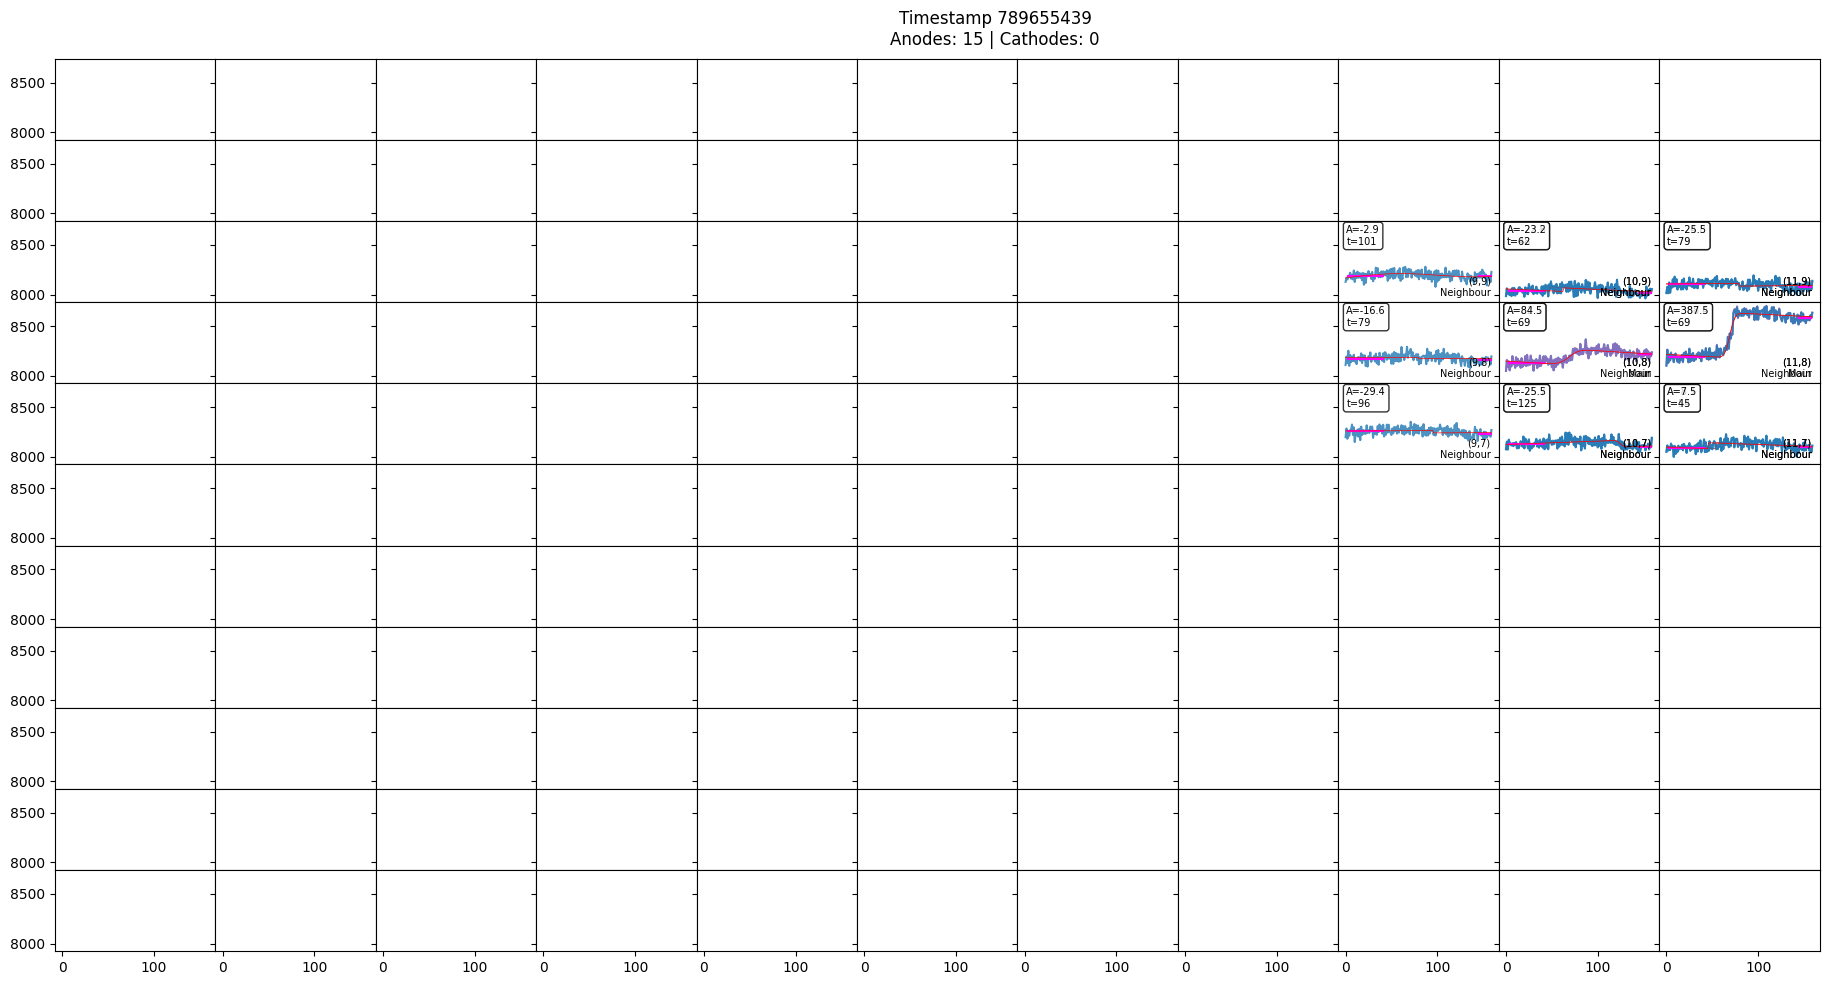

----------------------------------------------------------------------
Visualizing event with timestamp 791050127

Total triggered pixels: 10
All anodes (channels 1+3): 9
Cathodes (channel 2): 0 

Detailed channel breakdown:
  Main Anode: 8
  Cathode: 1
  Special Anode: 1

FINAL: 9 anode boxes plotted + 0 cathode boxes


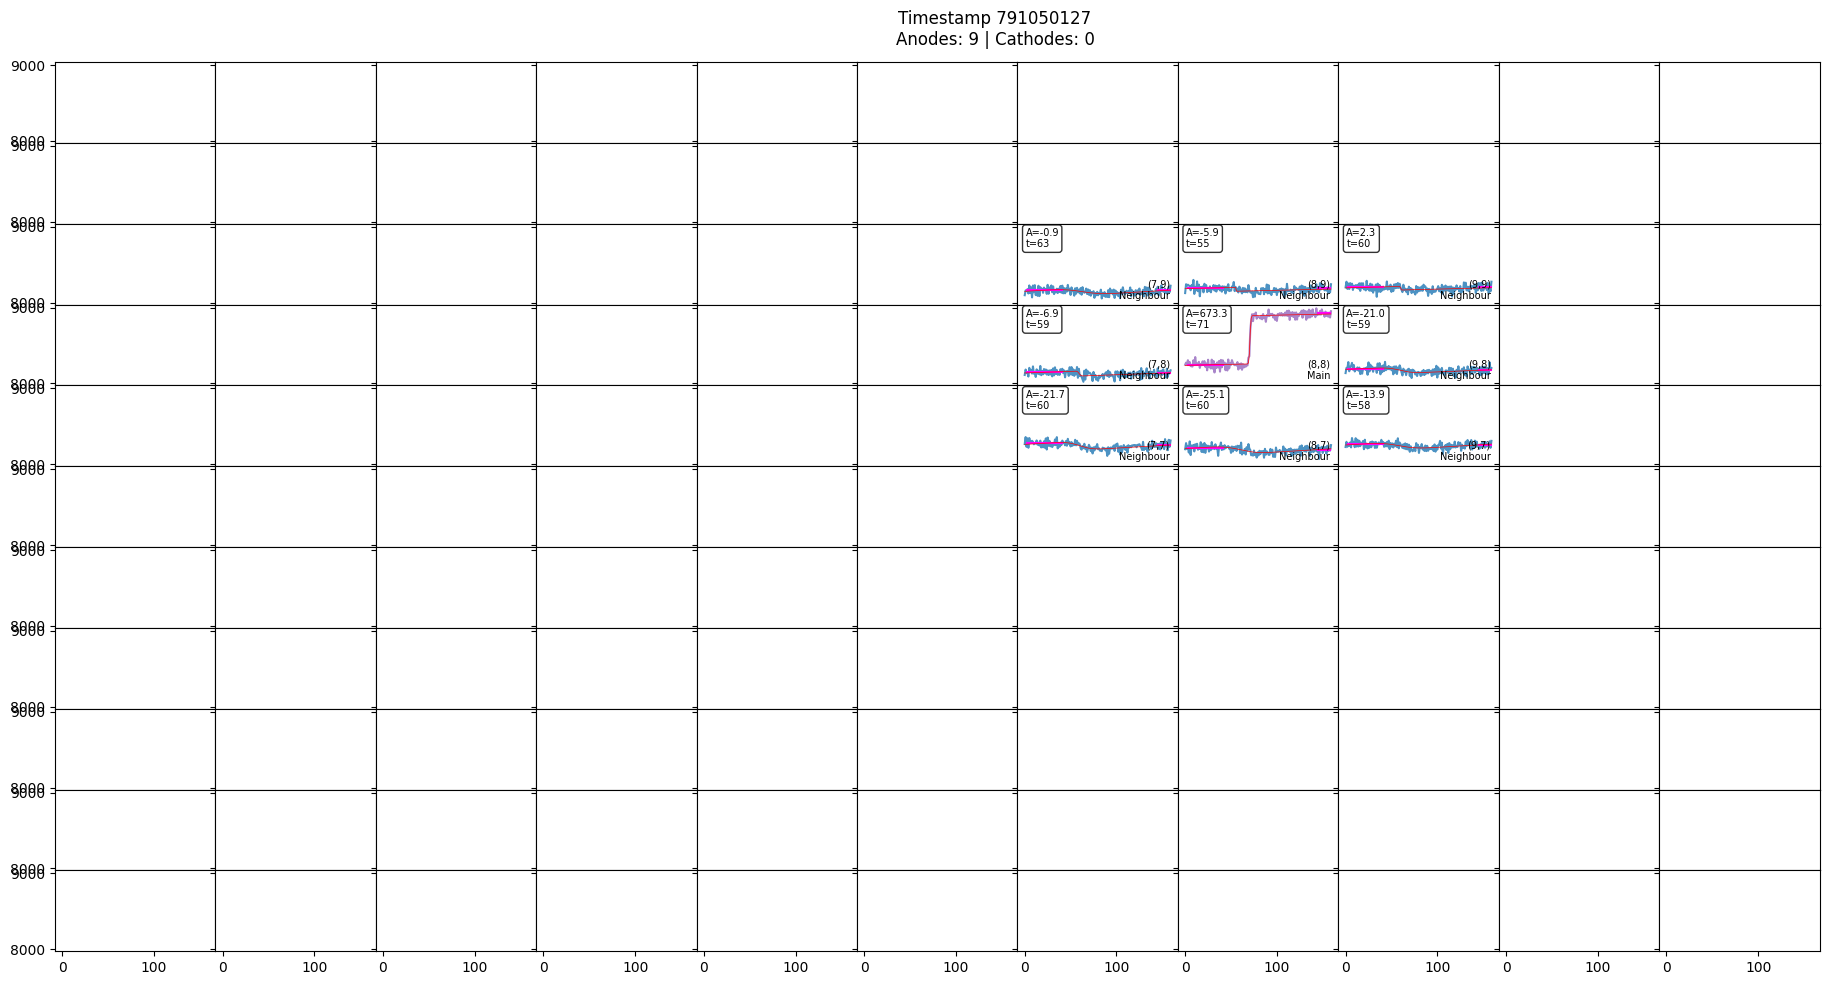

----------------------------------------------------------------------
Visualizing event with timestamp 793646525

Total triggered pixels: 10
All anodes (channels 1+3): 9
Cathodes (channel 2): 0 

Detailed channel breakdown:
  Main Anode: 8
  Cathode: 1
  Special Anode: 1

FINAL: 9 anode boxes plotted + 0 cathode boxes


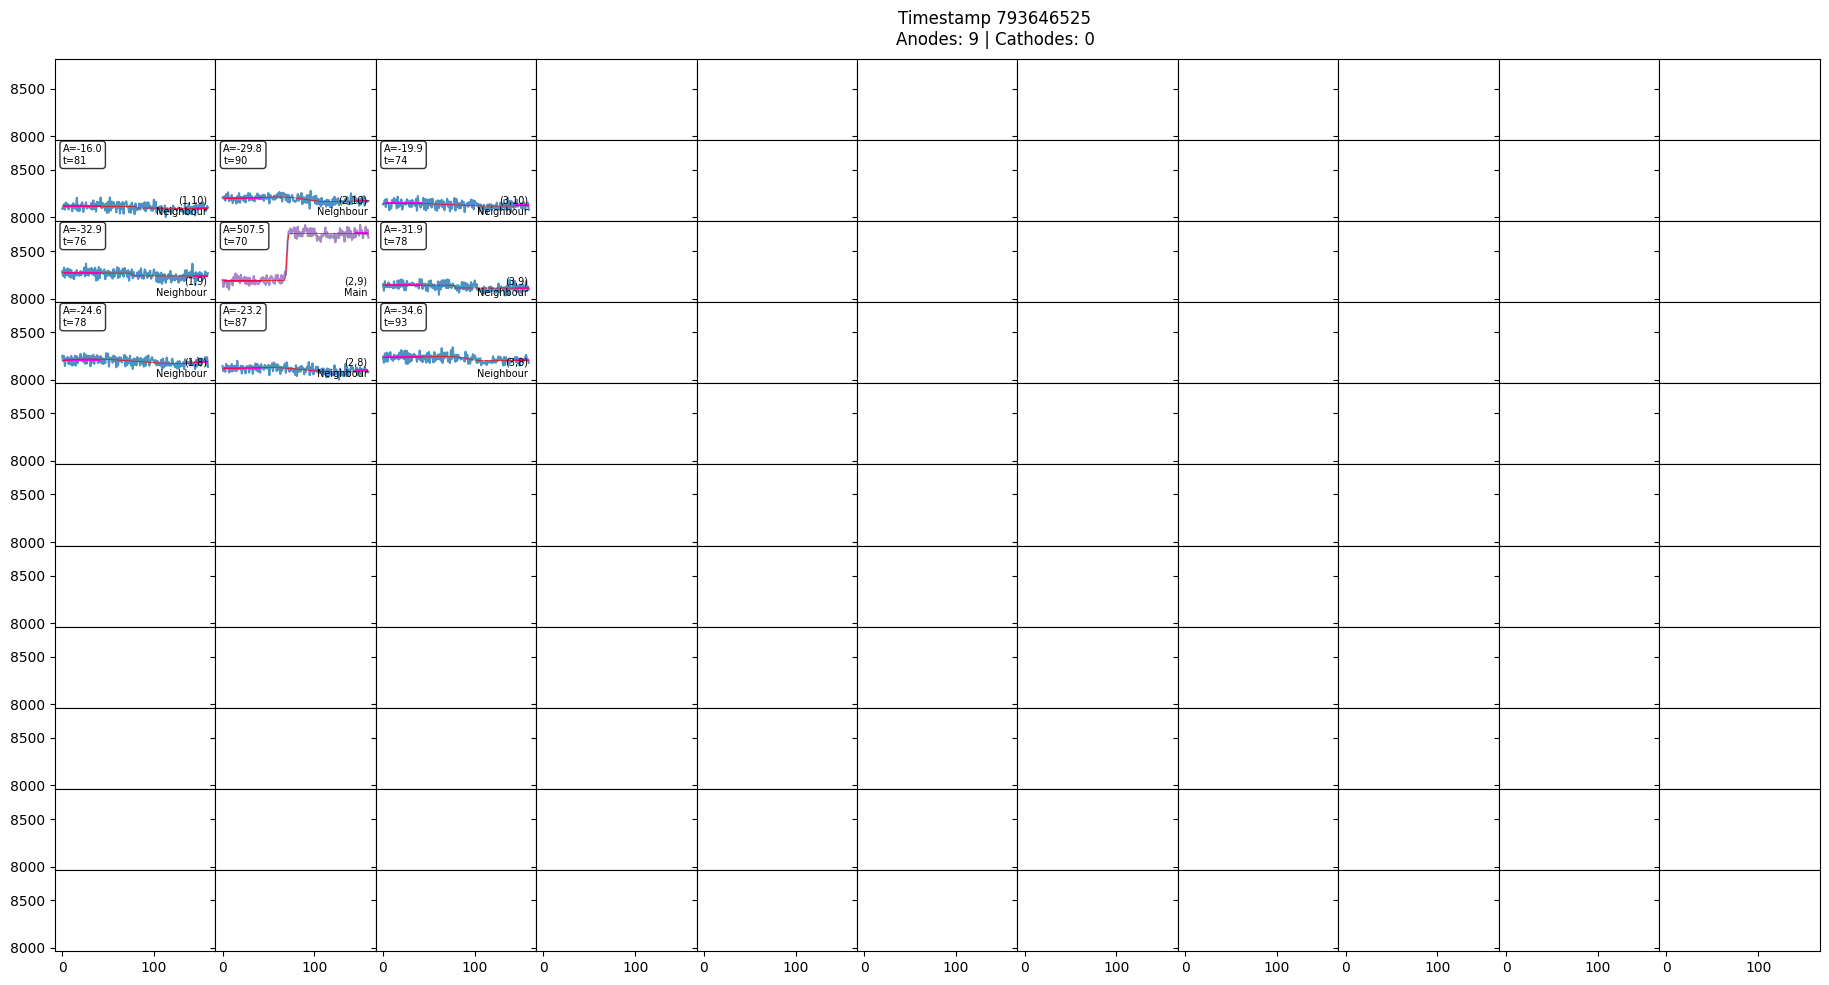

----------------------------------------------------------------------


In [36]:
def visualize_event_all_anodes(data_loader, timestamp_index=0):
    """Visualize event treating ALL anode types (1,2,3) as anodes"""
    timestamps = list(data_loader.event_groups.groups.keys())
    timestamp = timestamps[timestamp_index]
    event_df = data_loader.event_groups.get_group(timestamp)

    print(f"Visualizing event with timestamp {timestamp}\n")

    # GROUP ALL ANODE TYPES TOGETHER
    anode_mask = event_df['channel_flag'].isin([1, 3])  # Channels 1,2,3 are all anodes!
    cathode_mask = event_df['channel_flag'] == 0

    anodes_df = event_df[anode_mask]
    cathodes_df = event_df[cathode_mask]

    print(f"Total triggered pixels: {len(event_df)}")
    print(f"All anodes (channels 1+3): {len(anodes_df)}")
    print(f"Cathodes (channel 2): {len(cathodes_df)} \n")

    # Detailed channel breakdown
    channel_counts = event_df['channel_flag'].value_counts()
    print("Detailed channel breakdown:")
    channel_names = {1: 'Main Anode', 2: 'Cathode', 3: 'Special Anode'}
    for channel, count in channel_counts.items():
        name = channel_names.get(channel, f'Unknown[{channel}]')
        print(f"  {name}: {count}")

    # Create 11x12 grid
    fig, axs = plt.subplots(11, 12, figsize=(20, 10), sharex=True, sharey=True)

    # Hide the cathode (two top-right) boxes explicitly
    axs[0, 11].set_visible(False)
    axs[1, 11].set_visible(False)

    # Hide the extra column subplots
    for row in range(11):
        if row <= 1:
            continue
        axs[row, 11].set_visible(False)

    fig.suptitle(f"Timestamp {timestamp}\nAnodes: {len(anodes_df)} | Cathodes: {len(cathodes_df)}")

    wcfg = data_loader.config['waveform']
    x = np.arange(160)

    # Track plotted positions
    used_positions = set()
    anode_count = 0
    cathode_count = 0

    # PLOT ALL ANODES (Channels 1, 2, 3)
    for j, (idx, row) in enumerate(anodes_df.iterrows()):
        w = data_loader.waveforms[anodes_df.index[j]]

        # Coordinate mapping
        if 255 in (row.x, row.y):
            grid_row, grid_col = 0, 11
            position_key = "special"
        else:
            grid_row = 11 - int(row.y)
            grid_col = int(row.x) - 1
            position_key = f"{grid_row},{grid_col}"

        # Check for duplicates
        if position_key in used_positions and position_key != "special":
            print(f"   ⚠️  Overwriting anode at [{grid_row}, {grid_col}]")
        used_positions.add(position_key)

        ax = axs[grid_row, grid_col]
        anode_count += 1

        # Different colors for different anode types
        anode_colors = {
            1: "tab:blue",      # Main anodes - blue
            2: "tab:orange",    # Auxiliary anodes - orange
            3: "tab:purple"     # Special anodes - purple
        }

        color = anode_colors.get(row.channel_flag, "black")

        # Label showing anode type
        anode_labels = {1: "Neighbour", 3: "Main"}
        label = anode_labels.get(row.channel_flag, "Anode")
        ax.text(0.95, 0.05, f"({row.x},{row.y})\n{label}", transform=ax.transAxes,
                fontsize=7, verticalalignment="bottom", horizontalalignment="right")

        ax.plot(w, color, alpha=0.8, linewidth=1.5)

        # Process all anode types with anode settings
        low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
        high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
        amplitude = high - low

        # Plot baseline regions
        ax.plot([wcfg["anode_low_lim"][0], wcfg["anode_low_lim"][1]], [low, low], "magenta")
        ax.plot([wcfg["anode_high_lim"][0], wcfg["anode_high_lim"][1]], [high, high], "magenta")

        # Curve fitting
        try:
            popt, _ = curve_fit(stepish_func, x, w,
                              p0=(np.nanmean(x), np.min(w), np.max(w) - np.min(w), 1.0, 1.0),
                              maxfev=10000)
            pulse_time = popt[0]
            ax.plot(x, stepish_func(x, *popt), 'r-', linewidth=0.5)
            ax.text(0.05, 0.95, f"A={amplitude:.1f}\nt={pulse_time:.0f}",
                   transform=ax.transAxes, fontsize=7, verticalalignment="top",
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        except:
            ax.text(0.05, 0.95, f"A={amplitude:.1f}",
                   transform=ax.transAxes, fontsize=7, verticalalignment="top",
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # PLOT CATHODES (if any)
    for j, (idx, row) in enumerate(cathodes_df.iterrows()):
        w = data_loader.waveforms[cathodes_df.index[j]]

        # Coordinate mapping for cathodes
        if 255 in (row.x, row.y):
            grid_row, grid_col = 0, 11
        else:
            grid_row = 11 - int(row.y)
            grid_col = int(row.x) - 1

        ax = axs[grid_row, grid_col]
        cathode_count += 1

        ax.text(0.95, 0.85, f"({row.x},{row.y})\nCath", transform=ax.transAxes,
                fontsize=7, verticalalignment="bottom", horizontalalignment="right", color='red')

        ax.plot(w, "tab:red", alpha=0.6, linewidth=1.0)

    print(f"\nFINAL: {anode_count} anode boxes plotted + {cathode_count} cathode boxes")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Visualizations
print("VISUALIZING WITH ALL ANODE TYPES...")
for i in range(3):
    visualize_event_all_anodes(data_loader, i)
    print("-" * 70)

In [37]:
!python "createTrainData.py"

In [38]:
!python "simple_SuperRes_ResNet.py"

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Iter 0 - loss: 0.26052374
Figure(640x480)
Figure(640x480)
Iter 25 - loss: 0.051948853
Iter 50 - loss: 0.032693576
Iter 75 - loss: 0.02413578
Iter 100 - loss: 0.024686662
Iter 125 - loss: 0.019249506
Iter 150 - loss: 0.0155519
Iter 175 - loss: 0.013861971
Iter 200 - loss: 0.012541644
Iter 225 - loss: 0.01083426
Iter 250 - loss: 0.011050235
Iter 275 - loss: 0.010172058
Iter 300 - loss: 0.008995811
Iter 325 - loss: 0.008570176
Iter 350 - loss: 0.0080186175
Iter 375 - loss: 0.0074594705
Iter 400 - loss: 0.006850907
Ite

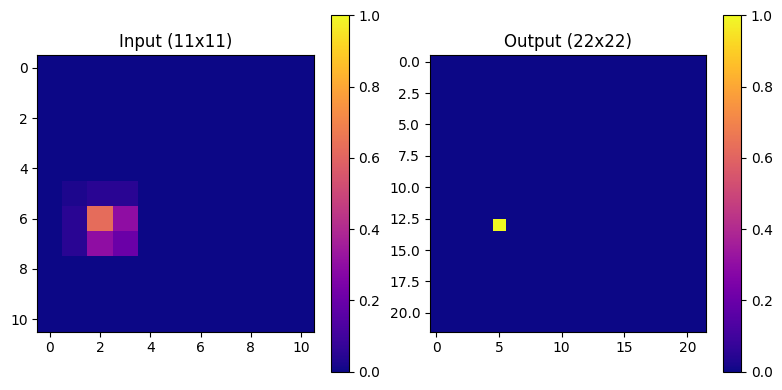

In [40]:
import numpy as np
import matplotlib.pyplot as plt

sampleData_in = np.load("sampleData_in.npy")
sampleData_out = np.load("sampleData_out.npy")

i = 0  # pick a sample index
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(sampleData_in[i], cmap='plasma', vmin=0, vmax=1)
plt.title("Input (11x11)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(sampleData_out[i], cmap='plasma', vmin=0, vmax=1)
plt.title("Output (22x22)")
plt.colorbar()

plt.tight_layout()
plt.show()

# Insights


*   Left (11x11 input): lower-resolution with the main event concentrated in the center, at coordinates (6,6)
*   Right (22x22 output): the result of the super-resolution model. It has a more precise localization.



Now the super-resolution tasks are applied to the BIN data.
Some changes are made to the provided createTrainData.py and sample_SuperRes_Net.py files:


*   Sharper signals: Reduced Gaussian sigma for clearer high-res targets
*   Simpler model: Fewer layers but more effective architecture
*   Proper normalization: Ensuring data is in [0,1] range
*   Synthetic test first: Verify the pipeline works before using real data
*   Better visualization: Clear comparison between input/target/prediction

Creat the input-ouput pairs

In [54]:
from scipy import ndimage

def add_sharp_gaussian(image, center_x, center_y, amplitude, sigma=0.4):
    """Add a sharp Gaussian spot"""
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    gaussian = amplitude * np.exp(-(distance**2) / (2 * sigma**2))
    return image + gaussian

def realistic_downsample(hr_image, low_res_size):
    """Realistic downsampling with optical blur"""
    # Apply optical blur
    blurred = ndimage.gaussian_filter(hr_image, sigma=0.8)

    # Average pooling
    block_size = hr_image.shape[0] // low_res_size
    lr_image = np.zeros((low_res_size, low_res_size))

    for i in range(low_res_size):
        for j in range(low_res_size):
            i_start = i * block_size
            i_end = min((i + 1) * block_size, hr_image.shape[0])
            j_start = j * block_size
            j_end = min((j + 1) * block_size, hr_image.shape[1])
            lr_image[i, j] = np.mean(blurred[i_start:i_end, j_start:j_end])

    return lr_image


def create_real_detector_data(ideas_loader, n_samples=1000, low_res_size=11, high_res_size=22):
    """Create Super Resolution training data from binary data"""
    print("Creating training data  detector events...")

    sampleData_in = np.zeros([n_samples, low_res_size, low_res_size])
    sampleData_out = np.zeros([n_samples, high_res_size, high_res_size])

    event_count = 0
    single_pixel_events = []

    # Collect single main event pixels (similar to calibrate's single_pixel logic)
    for timestamp, event_df in ideas_loader.event_groups:
        main_anodes = event_df[event_df.channel_flag == 3] # Main anode
        cathodes = event_df[event_df.channel_flag == 2] # Cathode

        # Consider an event a 'single pixel event' if it has exactly one main anode and one cathode
        if len(main_anodes) == 1 and len(cathodes) == 1:
            single_pixel_events.append((timestamp, event_df))

    print(f"Found {len(single_pixel_events)} single pixel events")

    if len(single_pixel_events) == 0:
        print("No single pixel events found meeting criteria. Falling back to all events for processing...")
        # Fallback to all events if specific single pixel events are not found
        # This fallback might still result in 0 samples if conditions inside loop are not met
        # or might process multi-pixel events as single if the loop logic doesn't distinguish
        events_to_process = list(ideas_loader.event_groups)
    else:
        events_to_process = single_pixel_events

    for timestamp, event_df in events_to_process:
        if event_count >= n_samples:
            break

        try:
            # Create high-resolution ground truth (22x22)
            hr_image = np.zeros((high_res_size, high_res_size))

            # Process the main anode (channel_flag == 3) for the ground truth
            # If falling back to all events, we assume the first main anode found is the target.
            target_anode_df = event_df[event_df.channel_flag == 3]

            if len(target_anode_df) == 0: # Skip if no main anode, especially if fallback is all events
                continue

            # For simplicity, if multiple main anodes, take the first one or the one with max amplitude (heuristic)
            # For this dataset, single_pixel_events ensures only one main anode.
            main_anode_row = target_anode_df.iloc[0]

            # Only process valid detector coordinates (1-11)
            if 1 <= main_anode_row.x <= 11 and 1 <= main_anode_row.y <= 11:
                # Convert to high-res coordinates (scale by 2)
                # Position the Gaussian in the center of the corresponding high-res cell
                hr_x = (main_anode_row.x - 1) * 2 + 0.5 # Center in high-res cell (0.5 offset for center)
                hr_y = (main_anode_row.y - 1) * 2 + 0.5

                # Get waveform and calculate amplitude
                w = ideas_loader.waveforms[main_anode_row.name]
                wcfg = ideas_loader.config['waveform']

                low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
                high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
                amplitude = max(0, high - low)

                # Only use events with reasonable amplitude
                if amplitude > 50:  # Adjust threshold based on data
                    # Create sharp spot in high-res image
                    hr_image = add_sharp_gaussian(hr_image, hr_x, hr_y, amplitude, sigma=0.5)

            # Skip if no meaningful signal was added to hr_image
            if np.max(hr_image) < 10: # Ensure there's a significant signal
                continue

            # Normalize high-res image to [0, 1]
            hr_max = np.max(hr_image)
            hr_image_normalized = hr_image / hr_max if hr_max > 0 else hr_image

            # Create low-resolution input by downsampling
            lr_image = realistic_downsample(hr_image_normalized, low_res_size)

            # Verify the data makes sense (ensure non-zero after downsampling)
            if np.max(lr_image) > 0.001 and np.max(hr_image_normalized) > 0.001: # Lowered threshold slightly
                sampleData_in[event_count] = lr_image
                sampleData_out[event_count] = hr_image_normalized
                event_count += 1

            if event_count % 100 == 0 and event_count > 0:
                print(f"Processed {event_count}/{n_samples} real events...")

        except Exception as e:
            # print(f"Error processing event (timestamp {timestamp}): {e}") # Uncomment for detailed debug
            continue

    # Trim to actual size
    sampleData_in = sampleData_in[:event_count]
    sampleData_out = sampleData_out[:event_count]

    print(f"Created {event_count} training samples from REAL data")

    # Visualize some samples to verify
    if event_count > 0: # Only visualize if samples were created
        visualize_real_data_samples(sampleData_in, sampleData_out, n_samples=min(3, event_count))

    return sampleData_in, sampleData_out

# Create the network for training model on pairs

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# class SimpleSuperResNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Feature extraction
#         self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
#         self.relu1 = nn.ReLU()

#         # Residual blocks
#         self.res1 = ResidualBlock(64)
#         self.res2 = ResidualBlock(64)
#         self.res3 = ResidualBlock(64)

#         # Upsampling
#         self.upsample = nn.Sequential(
#             nn.Conv2d(64, 256, 3, padding=1),
#             nn.PixelShuffle(2),  # 11x11 -> 22x22
#             nn.ReLU()
#         )

#         # Final output
#         self.final_conv = nn.Sequential(
#             nn.Conv2d(64, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 1, 3, padding=1),
#             nn.ReLU()  # Keep outputs positive
#         )

#     def forward(self, x):
#         # Initial features
#         x = self.relu1(self.conv1(x))

#         # Residual blocks
#         residual = x
#         x = self.res1(x)
#         x = self.res2(x)
#         x = self.res3(x)
#         x = x + residual  # Skip connection

#         # Upsample
#         x = self.upsample(x)

#         # Final output
#         x = self.final_conv(x)

#         return x
class SimpleSuperResNet(nn.Module):
    def __init__(self, input_size=11, output_size=22):
        super().__init__()

        # Initial feature extraction
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        # Residual blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )

        # Proper upsampling - use interpolation + convolution
        self.upsample = nn.Sequential(
            nn.Upsample(size=output_size, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.ReLU()  # Ensure positive outputs
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        x = self.final(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = self.relu(x)
        return x

# class DetectorDataset(Dataset):
#     def __init__(self, input_data, output_data):
#         self.input_data = input_data
#         self.output_data = output_data

#     def __len__(self):
#         return len(self.input_data)

#     def __getitem__(self, idx):
#         input_img = self.input_data[idx].astype(np.float32)
#         output_img = self.output_data[idx].astype(np.float32)

#         # Add channel dimension
#         input_tensor = torch.FloatTensor(input_img).unsqueeze(0)
#         output_tensor = torch.FloatTensor(output_img).unsqueeze(0)

#         return input_tensor, output_tensor

class DetectorDataset(Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data

        # Normalize data
        self.input_mean = np.mean(input_data)
        self.input_std = np.std(input_data)
        self.output_mean = np.mean(output_data)
        self.output_std = np.std(output_data)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_img = self.input_data[idx].astype(np.float32)
        output_img = self.output_data[idx].astype(np.float32)

        # Normalize
        input_img = (input_img - self.input_mean) / (self.input_std + 1e-8)
        output_img = (output_img - self.output_mean) / (self.output_std + 1e-8)

        # Add channel dimension
        input_tensor = torch.FloatTensor(input_img).unsqueeze(0)
        output_tensor = torch.FloatTensor(output_img).unsqueeze(0)

        return input_tensor, output_tensor

# Run on BIN

Loading binary data...
Loading cached data from scan_x0.13_y0.06_2025-10-23__11_25_26.npy
Loaded 947771 waveform records
Data shapes - waveforms: (947771, 160), timestamps: (947771,)
Found 86022 unique events
Found 86022 unique events
Creating training data from detector events...
Creating training data  detector events...
Found 66217 single pixel events
Processed 100/1000 real events...
Processed 200/1000 real events...
Processed 300/1000 real events...
Processed 400/1000 real events...
Processed 500/1000 real events...
Processed 600/1000 real events...
Processed 700/1000 real events...
Processed 800/1000 real events...
Processed 900/1000 real events...
Processed 1000/1000 real events...
Created 1000 training samples from REAL data


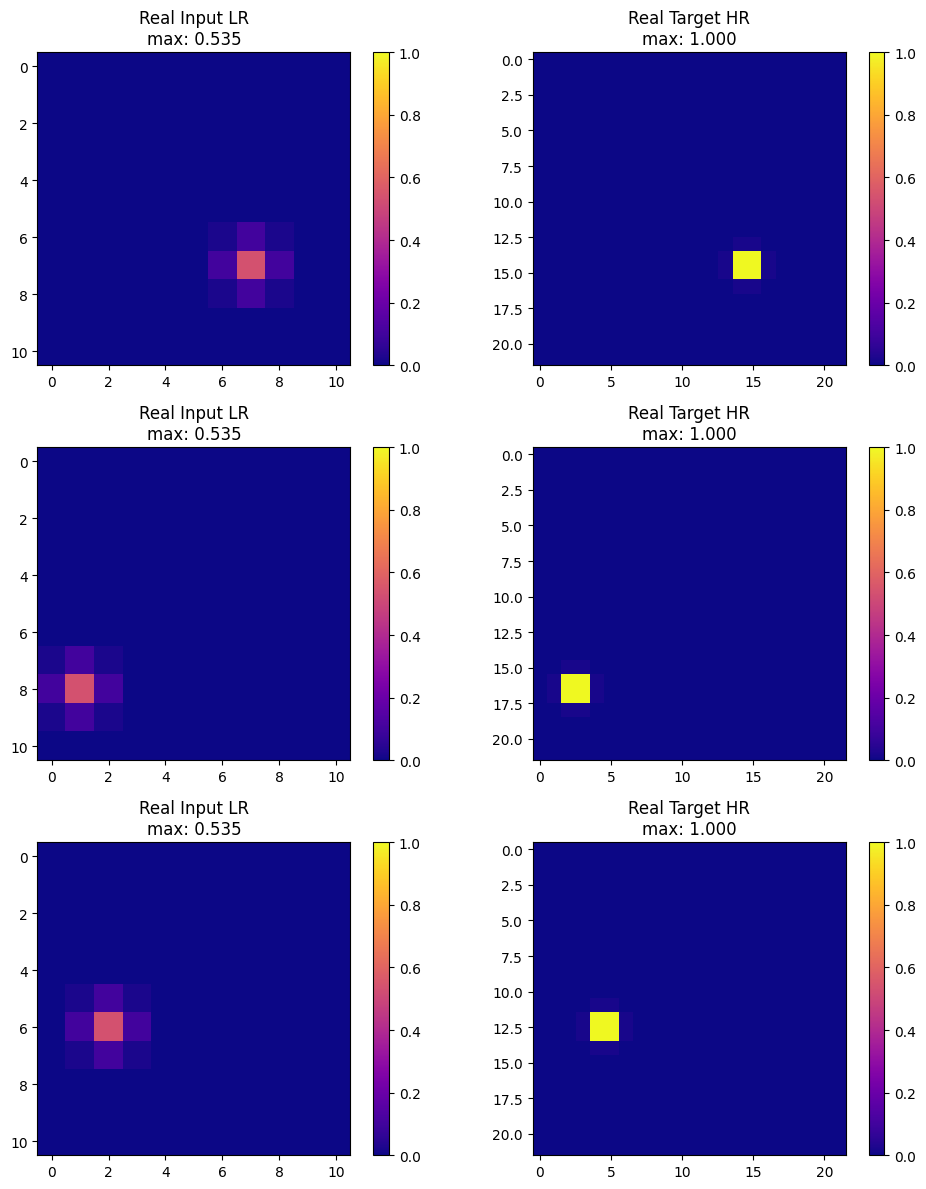

Saved 1000 real training samples
Training model on real data...
Using device: cuda
Epoch [0/100], Loss: 0.185243, LR: 1.00e-04


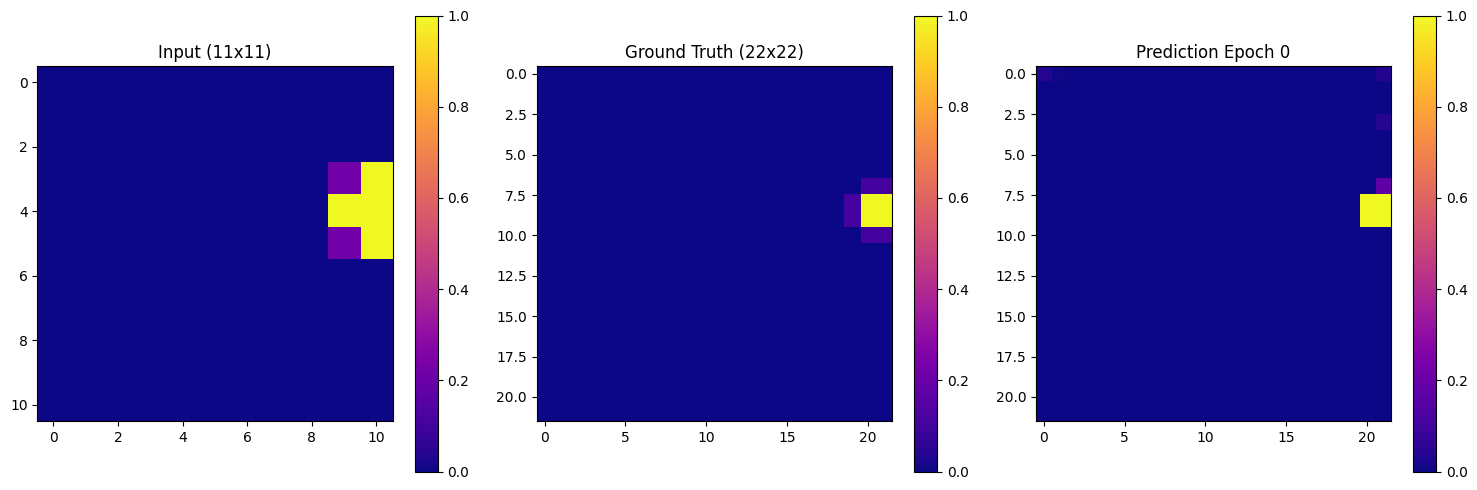

Epoch [10/100], Loss: 0.009017, LR: 1.00e-04
Epoch [20/100], Loss: 0.008968, LR: 1.00e-04


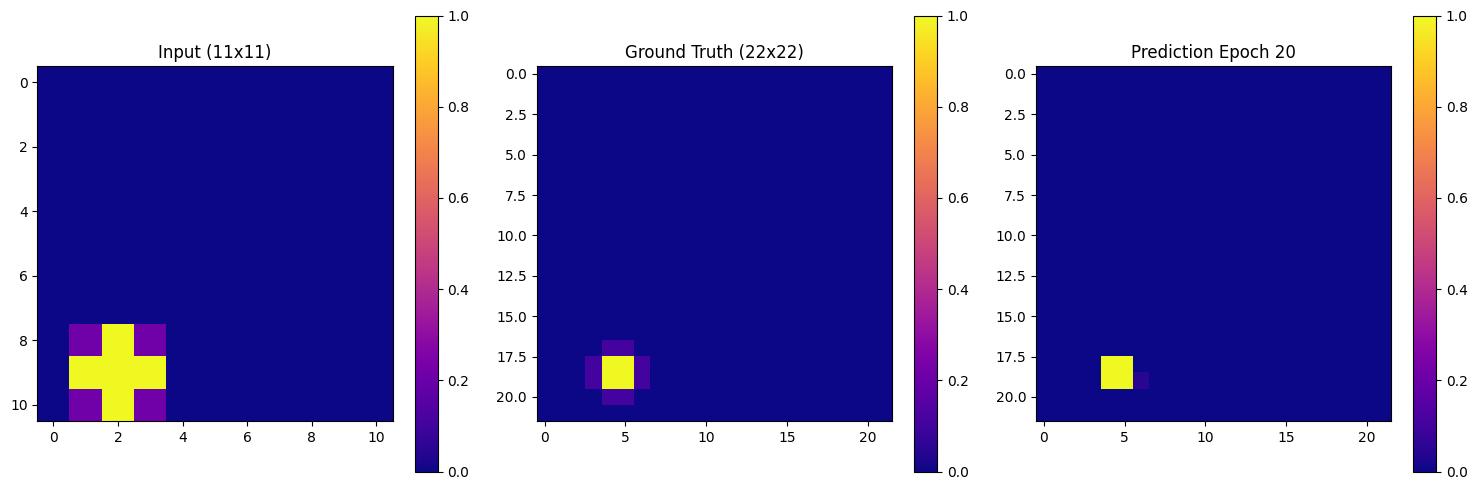

Epoch [30/100], Loss: 0.008864, LR: 1.00e-04
Epoch [40/100], Loss: 0.009053, LR: 1.00e-04


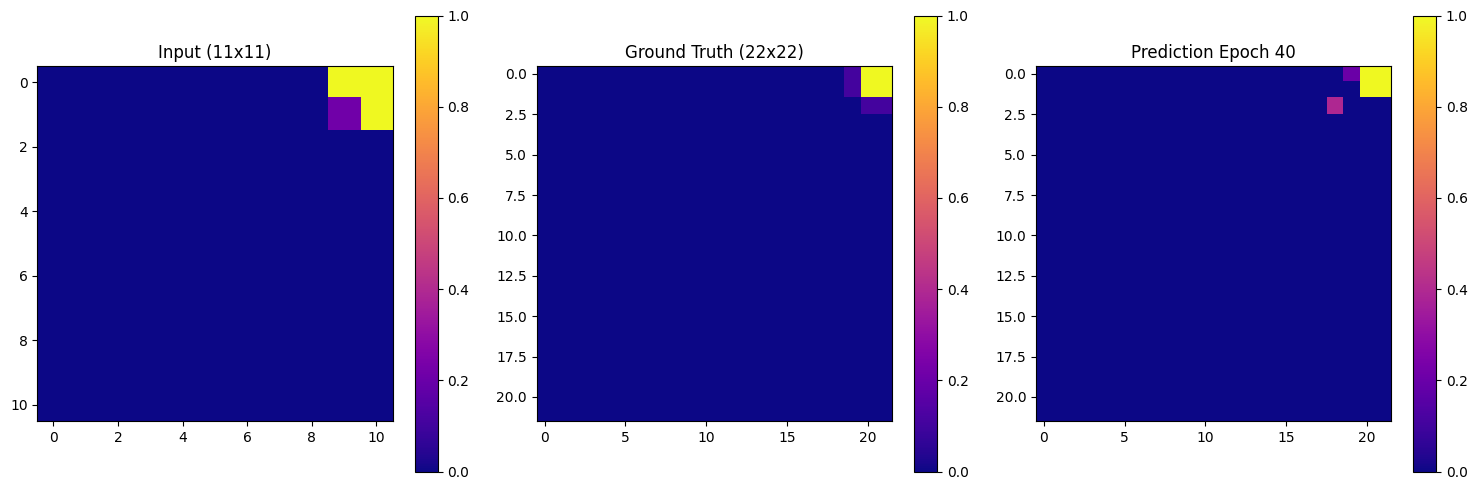

Epoch [50/100], Loss: 0.008788, LR: 5.00e-05
Epoch [60/100], Loss: 0.008773, LR: 5.00e-05


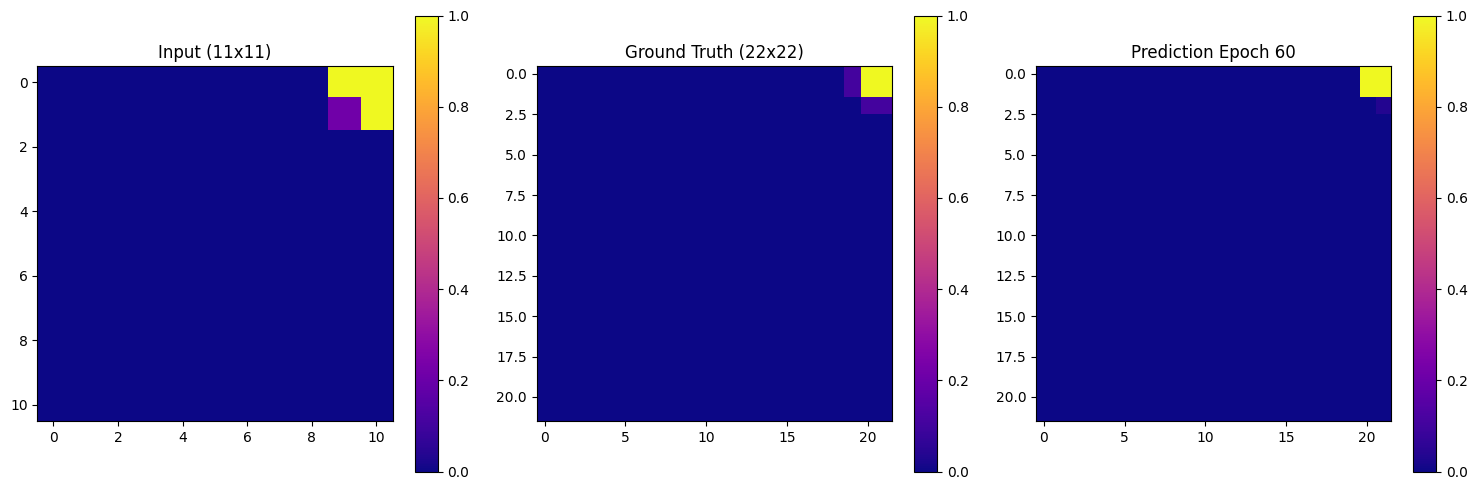

Epoch [70/100], Loss: 0.008777, LR: 5.00e-05
Epoch [80/100], Loss: 0.008763, LR: 2.50e-05


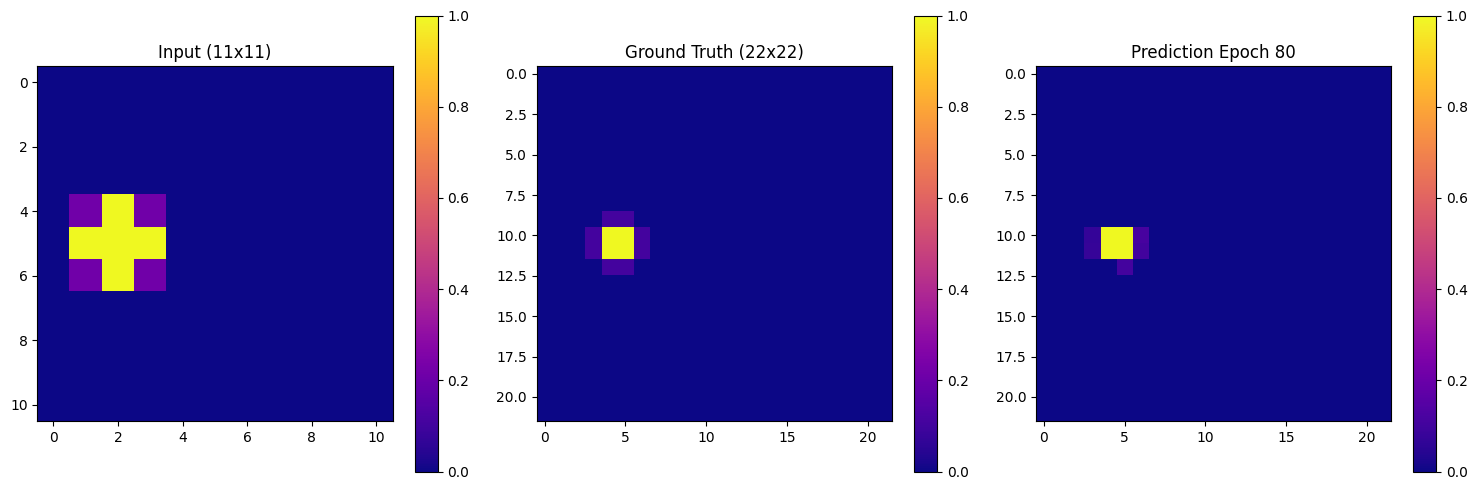

Epoch [90/100], Loss: 0.008763, LR: 2.50e-05


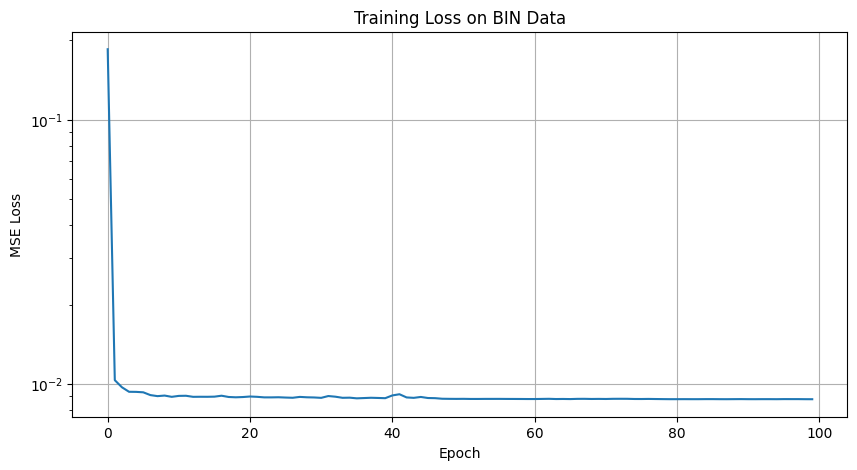

Model saved!


In [56]:
def run_on_bin():
    print("Loading binary data...")
    data_loader = Ideas(BINARY_DATA)
    data_loader.preprocess_events()

    print("Creating training data from detector events...")
    sampleData_in, sampleData_out = create_real_detector_data(
        data_loader,
        n_samples=1000,  # based on data size
        low_res_size=11,
        high_res_size=22
    )

    np.save('real_detector_data_in.npy', sampleData_in)
    np.save('real_detector_data_out.npy', sampleData_out)
    print(f"Saved {len(sampleData_in)} real training samples")

    print("Training model on real data...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dataset = DetectorDataset(sampleData_in, sampleData_out)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = SimpleSuperResNet(input_size=11, output_size=22).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Lower LR
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    n_epochs = 100
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0

        for batch_idx, (input_imgs, target_imgs) in enumerate(dataloader):
            input_imgs = input_imgs.to(device)
            target_imgs = target_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(input_imgs)

            # Check for NaN values
            if torch.isnan(outputs).any():
                print(f"NaN detected in outputs at epoch {epoch}, batch {batch_idx}")
                continue

            loss = criterion(outputs, target_imgs)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        if batch_count == 0:
            print(f"Epoch {epoch}: No valid batches")
            continue

        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {avg_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')

        if epoch % 20 == 0:
            visualize_results(model, dataset, device, epoch)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss on BIN Data')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # Save model
    torch.save(model.state_dict(), 'superres_real_detector_model.pth')
    print("Model saved!")


def visualize_results(model, dataset, device, epoch):
    model.eval()
    with torch.no_grad():
        idx = np.random.randint(len(dataset))
        input_img, target_img = dataset[idx]

        pred = model(input_img.unsqueeze(0).to(device))
        pred = pred.squeeze().cpu().numpy()
        input_img = input_img.squeeze().numpy()
        target_img = target_img.squeeze().numpy()

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        im0 = axes[0].imshow(input_img, cmap='plasma', vmin=0, vmax=1)
        axes[0].set_title('Input (11x11)')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(target_img, cmap='plasma', vmin=0, vmax=1)
        axes[1].set_title('Ground Truth (22x22)')
        plt.colorbar(im1, ax=axes[1])

        im2 = axes[2].imshow(pred, cmap='plasma', vmin=0, vmax=1)
        axes[2].set_title(f'Prediction Epoch {epoch}')
        plt.colorbar(im2, ax=axes[2])

        plt.tight_layout()
        plt.show()


run_on_bin()